In [3]:
import os
import numpy as np
import pandas as pd
import cv2
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
from pywt import dwt2
from sklearn.preprocessing import StandardScaler
from lime import lime_image
import matplotlib.pyplot as plt

# Function for extracting features
def extract_features(image):
    # Convert image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # DCT
    dct_features = cv2.dct(np.float32(gray) / 255.0)
    dct_features = dct_features.flatten()[:100]  # Top 100 coefficients

    # Pad or trim to make it exactly 100 coefficients if necessary
    if len(dct_features) < 100:
        dct_features = np.pad(dct_features, (0, 100 - len(dct_features)), 'constant')
    else:
        dct_features = dct_features[:100]

    # Wavelet Transform
    coeffs2 = dwt2(gray, 'haar')
    cA, (cH, cV, cD) = coeffs2
    wavelet_features = np.concatenate([cA.flatten(), cH.flatten(), cV.flatten(), cD.flatten()])[:100]

    # Pad or trim to make it exactly 100 coefficients if necessary
    if len(wavelet_features) < 100:
        wavelet_features = np.pad(wavelet_features, (0, 100 - len(wavelet_features)), 'constant')
    else:
        wavelet_features = wavelet_features[:100]

    # FFT
    f = np.fft.fft2(gray)
    fshift = np.fft.fftshift(f)
    epsilon = 1e-10  # To avoid log(0)
    magnitude_spectrum = 20 * np.log(np.abs(fshift) + epsilon)
    fft_features = magnitude_spectrum.flatten()[:100]  # Top 100 coefficients

    # Pad or trim to make it exactly 100 coefficients if necessary
    if len(fft_features) < 100:
        fft_features = np.pad(fft_features, (0, 100 - len(fft_features)), 'constant')
    else:
        fft_features = fft_features[:100]

    # Combine features
    features = np.concatenate([dct_features, wavelet_features, fft_features])

    # Check for NaN or infinite values
    if np.any(np.isnan(features)) or np.any(np.isinf(features)):
        return None  # Return None for invalid features

    return features

# Load dataset
def load_data(base_path):
    features, labels = [], []
    for label in ['real', 'fake']:
        folder_path = os.path.join(base_path, label)
        for image_name in os.listdir(folder_path):
            image_path = os.path.join(folder_path, image_name)
            image = cv2.imread(image_path)
            if image is not None:
                feature_vector = extract_features(image)
                if feature_vector is not None:  # Only append valid feature vectors
                    features.append(feature_vector)
                    labels.append(1 if label == 'real' else 0)  # 1 for real, 0 for fake
    return np.array(features), np.array(labels)

# Load training data
train_base_path = r"C:\Desktop\ML_Implementation\data(Final_ML)\train"
print("Loading training data...")
X_train, y_train = load_data(train_base_path)
print(f"Loaded {len(X_train)} training samples.")

# Load test data
test_base_path = r"C:\Desktop\ML_Implementation\data(Final_ML)\test"
print("Loading test data...")
X_test, y_test = load_data(test_base_path)
print(f"Loaded {len(X_test)} test samples.")

# Feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# k-NN classifier with GridSearchCV
param_grid = {'n_neighbors': list(range(1, 31))}
knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')
print("Training k-NN model with GridSearchCV...")
grid_search.fit(X_train, y_train)
print("Training completed.")

# Best estimator
best_knn = grid_search.best_estimator_
print(f"Best number of neighbors: {grid_search.best_params_['n_neighbors']}")

# Predictions
y_pred_train = best_knn.predict(X_train)
y_pred_test = best_knn.predict(X_test)

# Confusion Matrix for Train and Test
conf_matrix_train = confusion_matrix(y_train, y_pred_train)
conf_matrix_test = confusion_matrix(y_test, y_pred_test)

# Classification Report
class_report_train = classification_report(y_train, y_pred_train, target_names=['Real', 'Fake'], output_dict=True)
class_report_test = classification_report(y_test, y_pred_test, target_names=['Real', 'Fake'], output_dict=True)

# Convert confusion matrix to DataFrame
conf_matrix_train_df = pd.DataFrame(conf_matrix_train, 
                                     index=['Actual_Real', 'Actual_Fake'], 
                                     columns=['Predicted_Real', 'Predicted_Fake'])
conf_matrix_test_df = pd.DataFrame(conf_matrix_test, 
                                    index=['Actual_Real', 'Actual_Fake'], 
                                    columns=['Predicted_Real', 'Predicted_Fake'])

# Save confusion matrices and reports to Excel
with pd.ExcelWriter('Final_ML_Classification_results.xlsx') as writer:
    conf_matrix_train_df.to_excel(writer, sheet_name='Confusion_Matrix_Train')
    conf_matrix_test_df.to_excel(writer, sheet_name='Confusion_Matrix_Test')
    pd.DataFrame(class_report_train).transpose().to_excel(writer, sheet_name='Classification_Report_Train')
    pd.DataFrame(class_report_test).transpose().to_excel(writer, sheet_name='Classification_Report_Test')

print("Results saved to Excel.")


Loading training data...
Loaded 5365 training samples.
Loading test data...
Loaded 2185 test samples.
Training k-NN model with GridSearchCV...
Training completed.
Best number of neighbors: 29
Results saved to Excel.


In [4]:
import lime
import lime.lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

# Redefine the predict_proba function for LIME to predict using the original images
def predict_proba_fn(images):
    # Extract features for each image in the batch
    features = np.array([extract_features(image) for image in images])
    features = scaler.transform(features)  # Scale the features using the fitted scaler
    return best_knn.predict_proba(features)  # Use the kNN model to predict probabilities

# Initialize LIME explainer for images
explainer = lime.lime_image.LimeImageExplainer()

# Load original images for X_test (before feature extraction)
def load_images(base_path):
    images, labels = [], []
    for label in ['real', 'fake']:
        folder_path = os.path.join(base_path, label)
        for image_name in os.listdir(folder_path):
            image_path = os.path.join(folder_path, image_name)
            image = cv2.imread(image_path)
            images.append(image)
            labels.append(1 if label == 'real' else 0)  # 1 for real, 0 for fake
    return np.array(images), np.array(labels)

# Function to classify images into TP, TN, FP, FN
def classify_images(y_true, y_pred):
    tp = np.where((y_true == 1) & (y_pred == 1))[0]  # True Positives
    tn = np.where((y_true == 0) & (y_pred == 0))[0]  # True Negatives
    fp = np.where((y_true == 0) & (y_pred == 1))[0]  # False Positives
    fn = np.where((y_true == 1) & (y_pred == 0))[0]  # False Negatives
    return tp, tn, fp, fn

# Apply LIME to test dataset with original images and visualize TP, TN, FP, FN
def apply_lime_to_dataset(images, labels, dataset_type='Test'):
    # Predict the labels using the classifier (for classification of TP, TN, FP, FN)
    y_pred = best_knn.predict([extract_features(image) for image in images])
    
    tp, tn, fp, fn = classify_images(labels, y_pred)
    
    # Limit to 3 images per classification
    tp = tp[:3]
    tn = tn[:3]
    fp = fp[:3]
    fn = fn[:3]
    
    # Create the folder structure for saving images
    output_folder = f"lime_knn/{dataset_type}"
    os.makedirs(output_folder, exist_ok=True)

    # Save the LIME explanations for each classification type
    for i, idx in enumerate(tp):
        print(f"Generating LIME for True Positive {i}")
        save_lime(images[idx], f"True Positive {i}", output_folder)
    
    for i, idx in enumerate(tn):
        print(f"Generating LIME for True Negative {i}")
        save_lime(images[idx], f"True Negative {i}", output_folder)
    
    for i, idx in enumerate(fp):
        print(f"Generating LIME for False Positive {i}")
        save_lime(images[idx], f"False Positive {i}", output_folder)
    
    for i, idx in enumerate(fn):
        print(f"Generating LIME for False Negative {i}")
        save_lime(images[idx], f"False Negative {i}", output_folder)

# Function to generate LIME explanations, visualize and save them
def save_lime(image, label, output_folder):
    # Convert to grayscale for explanation
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Generate explanation for the instance
    explanation = explainer.explain_instance(
        image=gray_image,          # Pass the grayscale image
        classifier_fn=predict_proba_fn,  # Prediction function using original images
        top_labels=2,               # Number of top labels to explain
        hide_color=0,               # Color to hide areas (black in this case)
        num_samples=50            # Number of perturbations LIME will generate
    )

    # Visualize the explanation for each image
    temp, mask = explanation.get_image_and_mask(
        explanation.top_labels[0],  # Label to explain
        positive_only=False,        # Show both positive and negative contributions
        num_features=10,            # Number of superpixels (features) to show
        hide_rest=False             # Show the entire image
    )

    # Prepare filenames
    original_image_filename = os.path.join(output_folder, f"{label}_original.jpg")
    lime_image_filename = os.path.join(output_folder, f"{label}_lime.jpg")

    # Plot and save the original image with LIME explanation
    plt.figure(figsize=(10, 10))

    # Display original image
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(f'{label} - Original Image')
    plt.axis('off')  # Turn off axis

    # Display LIME explanation with boundaries
    plt.subplot(1, 2, 2)
    plt.imshow(mark_boundaries(temp, mask, color=(1, 0, 0), mode='thick'))
    plt.title(f'LIME Explanation for {label}')
    plt.axis('off')  # Turn off axis

    # Save the plot
    plt.savefig(lime_image_filename)
    plt.close()

# Load original train and test images (before feature extraction)
base_path_train = r"C:\Desktop\ML_Implementation\data(Final_ML)\train"
base_path_test = r"C:\Desktop\ML_Implementation\data(Final_ML)\test"

image_train, y_train = load_images(base_path_train)
image_test, y_test = load_images(base_path_test)

# Apply LIME to the train dataset (True Positive, True Negative, False Positive, False Negative)
print("Applying LIME to Train Dataset...")
apply_lime_to_dataset(image_train, y_train, dataset_type='train')

# Apply LIME to the test dataset (True Positive, True Negative, False Positive, False Negative)
print("Applying LIME to Test Dataset...")
apply_lime_to_dataset(image_test, y_test, dataset_type='test')


Applying LIME to Train Dataset...
Generating LIME for True Positive 0


  0%|          | 0/50 [00:00<?, ?it/s]

Generating LIME for True Positive 1


  0%|          | 0/50 [00:00<?, ?it/s]

Generating LIME for True Positive 2


  0%|          | 0/50 [00:00<?, ?it/s]

Generating LIME for True Negative 0


  0%|          | 0/50 [00:00<?, ?it/s]

Generating LIME for True Negative 1


  0%|          | 0/50 [00:00<?, ?it/s]

Generating LIME for True Negative 2


  0%|          | 0/50 [00:00<?, ?it/s]

Generating LIME for False Positive 0


  0%|          | 0/50 [00:00<?, ?it/s]

Generating LIME for False Positive 1


  0%|          | 0/50 [00:00<?, ?it/s]

Generating LIME for False Positive 2


  0%|          | 0/50 [00:00<?, ?it/s]

Generating LIME for False Negative 0


  0%|          | 0/50 [00:00<?, ?it/s]

Generating LIME for False Negative 1


  0%|          | 0/50 [00:00<?, ?it/s]

Generating LIME for False Negative 2


  0%|          | 0/50 [00:00<?, ?it/s]

Applying LIME to Test Dataset...
Generating LIME for True Positive 0


  0%|          | 0/50 [00:00<?, ?it/s]

Generating LIME for True Positive 1


  0%|          | 0/50 [00:00<?, ?it/s]

Generating LIME for True Positive 2


  0%|          | 0/50 [00:00<?, ?it/s]

Generating LIME for True Negative 0


  0%|          | 0/50 [00:00<?, ?it/s]

Generating LIME for True Negative 1


  0%|          | 0/50 [00:00<?, ?it/s]

Generating LIME for True Negative 2


  0%|          | 0/50 [00:00<?, ?it/s]

Generating LIME for False Positive 0


  0%|          | 0/50 [00:00<?, ?it/s]

Generating LIME for False Positive 1


  0%|          | 0/50 [00:00<?, ?it/s]

Generating LIME for False Positive 2


  0%|          | 0/50 [00:00<?, ?it/s]

Generating LIME for False Negative 0


  0%|          | 0/50 [00:00<?, ?it/s]

Generating LIME for False Negative 1


  0%|          | 0/50 [00:00<?, ?it/s]

Generating LIME for False Negative 2


  0%|          | 0/50 [00:00<?, ?it/s]

In [5]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report

# Sigmoid function for probabilities
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Perceptron implementation with sigmoid for probability
class Perceptron:
    def __init__(self, learning_rate=0.01, n_iters=1000):
        self.lr = learning_rate
        self.n_iters = n_iters
        self.weights = None
        self.bias = None

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0

        for _ in range(self.n_iters):
            for idx, x_i in enumerate(X):
                linear_output = np.dot(x_i, self.weights) + self.bias
                y_predicted = self._activation_function(linear_output)
                update = self.lr * (y[idx] - y_predicted)
                self.weights += update * x_i
                self.bias += update

    def predict(self, X):
        linear_output = np.dot(X, self.weights) + self.bias
        y_predicted = self._activation_function(linear_output)
        return y_predicted

    def predict_proba(self, X):
        linear_output = np.dot(X, self.weights) + self.bias
        proba = sigmoid(linear_output)
        return np.stack([1 - proba, proba], axis=1)

    def _activation_function(self, x):
        return np.where(x >= 0, 1, 0)

# Initialize and train the Perceptron
perceptron = Perceptron(learning_rate=0.01, n_iters=1000)
perceptron.fit(X_train, y_train)

# Make predictions
y_pred = perceptron.predict(X_test)

# Evaluation
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred, target_names=['Real', 'Fake'], output_dict=True)

# Convert confusion matrix to DataFrame
conf_matrix_df = pd.DataFrame(conf_matrix, 
                               index=['Actual_Real', 'Actual_Fake'], 
                               columns=['Predicted_Real', 'Predicted_Fake'])

# Convert classification report to DataFrame
class_report_df = pd.DataFrame(class_report).transpose()

# Save both confusion matrix and classification report to Excel
excel_filename = 'perceptron_class.xlsx'
with pd.ExcelWriter(excel_filename) as writer:
    conf_matrix_df.to_excel(writer, sheet_name='Confusion_Matrix')
    class_report_df.to_excel(writer, sheet_name='Classification_Report')

print(f"Evaluation results saved to {excel_filename}")


Evaluation results saved to perceptron_class.xlsx


In [6]:
import lime
import lime.lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

# Redefine the predict_proba function for LIME to predict using the perceptron model
def predict_proba_fn(images):
    # Extract features for each image in the batch
    features = np.array([extract_features(image) for image in images])
    features = scaler.transform(features)  # Scale the features using the fitted scaler
    return perceptron.predict_proba(features)  # Use the perceptron model to predict probabilities

# Initialize LIME explainer for images
explainer = lime.lime_image.LimeImageExplainer()

# Load original images for X_test (before feature extraction)
def load_images(base_path):
    images, labels = [], []
    for label in ['real', 'fake']:
        folder_path = os.path.join(base_path, label)
        for image_name in os.listdir(folder_path):
            image_path = os.path.join(folder_path, image_name)
            image = cv2.imread(image_path)
            images.append(image)
            labels.append(1 if label == 'real' else 0)  # 1 for real, 0 for fake
    return np.array(images), np.array(labels)

# Function to classify images into TP, TN, FP, FN
def classify_images(y_true, y_pred):
    tp = np.where((y_true == 1) & (y_pred == 1))[0]  # True Positives
    tn = np.where((y_true == 0) & (y_pred == 0))[0]  # True Negatives
    fp = np.where((y_true == 0) & (y_pred == 1))[0]  # False Positives
    fn = np.where((y_true == 1) & (y_pred == 0))[0]  # False Negatives
    return tp, tn, fp, fn

# Apply LIME to test dataset with original images and visualize TP, TN, FP, FN
def apply_lime_to_dataset(images, labels, dataset_type='Test'):
    # Predict the labels using the classifier (for classification of TP, TN, FP, FN)
    y_pred = perceptron.predict([extract_features(image) for image in images])
    
    tp, tn, fp, fn = classify_images(labels, y_pred)
    
    # Limit to 3 images per classification
    tp = tp[:3]
    tn = tn[:3]
    fp = fp[:3]
    fn = fn[:3]
    
    # Create the folder structure for saving images
    output_folder = f"lime_perceptron/{dataset_type}"
    os.makedirs(output_folder, exist_ok=True)

    # Save the LIME explanations for each classification type
    for i, idx in enumerate(tp):
        print(f"Generating LIME for True Positive {i}")
        save_lime(images[idx], f"True Positive {i}", output_folder)
    
    for i, idx in enumerate(tn):
        print(f"Generating LIME for True Negative {i}")
        save_lime(images[idx], f"True Negative {i}", output_folder)
    
    for i, idx in enumerate(fp):
        print(f"Generating LIME for False Positive {i}")
        save_lime(images[idx], f"False Positive {i}", output_folder)
    
    for i, idx in enumerate(fn):
        print(f"Generating LIME for False Negative {i}")
        save_lime(images[idx], f"False Negative {i}", output_folder)

# Function to generate LIME explanations, visualize and save them
def save_lime(image, label, output_folder):
    # Convert to grayscale for explanation
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Generate explanation for the instance
    explanation = explainer.explain_instance(
        image=gray_image,          # Pass the grayscale image
        classifier_fn=predict_proba_fn,  # Prediction function using perceptron model
        top_labels=2,               # Number of top labels to explain
        hide_color=0,               # Color to hide areas (black in this case)
        num_samples=50            # Number of perturbations LIME will generate
    )

    # Visualize the explanation for each image
    temp, mask = explanation.get_image_and_mask(
        explanation.top_labels[0],  # Label to explain
        positive_only=False,        # Show both positive and negative contributions
        num_features=10,            # Number of superpixels (features) to show
        hide_rest=False             # Show the entire image
    )

    # Prepare filenames
    original_image_filename = os.path.join(output_folder, f"{label}_original.jpg")
    lime_image_filename = os.path.join(output_folder, f"{label}_lime.jpg")

    # Plot and save the original image with LIME explanation
    plt.figure(figsize=(10, 10))

    # Display original image
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(f'{label} - Original Image')
    plt.axis('off')  # Turn off axis

    # Display LIME explanation with boundaries
    plt.subplot(1, 2, 2)
    plt.imshow(mark_boundaries(temp, mask, color=(1, 0, 0), mode='thick'))
    plt.title(f'LIME Explanation for {label}')
    plt.axis('off')  # Turn off axis

    # Save the plot
    plt.savefig(lime_image_filename)
    plt.close()

# Load original train and test images (before feature extraction)
base_path_train = r"C:\Desktop\ML_Implementation\data(Final_ML)\train"
base_path_test = r"C:\Desktop\ML_Implementation\data(Final_ML)\test"

image_train, y_train = load_images(base_path_train)
image_test, y_test = load_images(base_path_test)

# Apply LIME to the train dataset (True Positive, True Negative, False Positive, False Negative)
print("Applying LIME to Train Dataset...")
apply_lime_to_dataset(image_train, y_train, dataset_type='train')

# Apply LIME to the test dataset (True Positive, True Negative, False Positive, False Negative)
print("Applying LIME to Test Dataset...")
apply_lime_to_dataset(image_test, y_test, dataset_type='test')


Applying LIME to Train Dataset...
Generating LIME for True Positive 0


  0%|          | 0/50 [00:00<?, ?it/s]

Generating LIME for True Positive 1


  0%|          | 0/50 [00:00<?, ?it/s]

Generating LIME for True Positive 2


  0%|          | 0/50 [00:00<?, ?it/s]

Generating LIME for True Negative 0


  0%|          | 0/50 [00:00<?, ?it/s]

Generating LIME for True Negative 1


  0%|          | 0/50 [00:00<?, ?it/s]

Generating LIME for True Negative 2


  0%|          | 0/50 [00:00<?, ?it/s]

Generating LIME for False Positive 0


  0%|          | 0/50 [00:00<?, ?it/s]

Generating LIME for False Positive 1


  0%|          | 0/50 [00:00<?, ?it/s]

Generating LIME for False Positive 2


  0%|          | 0/50 [00:00<?, ?it/s]

Generating LIME for False Negative 0


  0%|          | 0/50 [00:00<?, ?it/s]

Generating LIME for False Negative 1


  0%|          | 0/50 [00:00<?, ?it/s]

Generating LIME for False Negative 2


  0%|          | 0/50 [00:00<?, ?it/s]

Applying LIME to Test Dataset...
Generating LIME for True Positive 0


  0%|          | 0/50 [00:00<?, ?it/s]

Generating LIME for True Positive 1


  0%|          | 0/50 [00:00<?, ?it/s]

Generating LIME for True Positive 2


  0%|          | 0/50 [00:00<?, ?it/s]

Generating LIME for True Negative 0


  0%|          | 0/50 [00:00<?, ?it/s]

Generating LIME for True Negative 1


  0%|          | 0/50 [00:00<?, ?it/s]

Generating LIME for True Negative 2


  0%|          | 0/50 [00:00<?, ?it/s]

Generating LIME for False Positive 0


  0%|          | 0/50 [00:00<?, ?it/s]

Generating LIME for False Positive 1


  0%|          | 0/50 [00:00<?, ?it/s]

Generating LIME for False Positive 2


  0%|          | 0/50 [00:00<?, ?it/s]

Generating LIME for False Negative 0


  0%|          | 0/50 [00:00<?, ?it/s]

Generating LIME for False Negative 1


  0%|          | 0/50 [00:00<?, ?it/s]

Generating LIME for False Negative 2


  0%|          | 0/50 [00:00<?, ?it/s]

In [7]:
import pandas as pd
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

# Initialize SVM classifier
svm_classifier = SVC(kernel='linear', random_state=42, probability=True)

# Train the model on the full training set
svm_classifier.fit(X_train, y_train)

# Make predictions
y_pred = svm_classifier.predict(X_test)

# Performance metrics
class_report = classification_report(y_test, y_pred, output_dict=True)
conf_matrix = confusion_matrix(y_test, y_pred)
y_prob = svm_classifier.predict_proba(X_test)  # This will return the predicted probabilities

# Print performance metrics
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", conf_matrix)
print("Predicted Probabilities:\n", y_prob)

# Convert classification report to DataFrame
class_report_df = pd.DataFrame(class_report).transpose()

# Convert confusion matrix to DataFrame
conf_matrix_df = pd.DataFrame(conf_matrix, columns=['Predicted Real', 'Predicted fake'], index=['Actual Real', 'Actual fake'])

# Convert predicted probabilities to DataFrame
y_prob_df = pd.DataFrame(y_prob, columns=[f'Prob_0', f'Prob_1'])

# Save results to Excel
with pd.ExcelWriter('svm_predict_results.xlsx') as writer:
    class_report_df.to_excel(writer, sheet_name='Classification Report')
    conf_matrix_df.to_excel(writer, sheet_name='Confusion Matrix')
    y_prob_df.to_excel(writer, sheet_name='Predicted Probabilities')

print("Results have been saved to 'svm_predict_results.xlsx'")


Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.72      0.73       965
           1       0.78      0.80      0.79      1220

    accuracy                           0.77      2185
   macro avg       0.76      0.76      0.76      2185
weighted avg       0.77      0.77      0.77      2185

Confusion Matrix:
 [[696 269]
 [243 977]]
Predicted Probabilities:
 [[0.09779711 0.90220289]
 [0.47004137 0.52995863]
 [0.15254014 0.84745986]
 ...
 [0.85644969 0.14355031]
 [0.74718687 0.25281313]
 [0.42635362 0.57364638]]
Results have been saved to 'svm_predict_results.xlsx'


In [8]:
import lime
import lime.lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

# Redefine the predict_proba function for LIME to predict using the SVM model
def predict_proba_fn(images):
    # Extract features for each image in the batch
    features = np.array([extract_features(image) for image in images])
    features = scaler.transform(features)  # Scale the features using the fitted scaler
    return svm_classifier.predict_proba(features)  # Use the SVM model to predict probabilities

# Initialize LIME explainer for images
explainer = lime.lime_image.LimeImageExplainer()

# Load original images for X_test (before feature extraction)
def load_images(base_path):
    images, labels = [], []
    for label in ['real', 'fake']:
        folder_path = os.path.join(base_path, label)
        for image_name in os.listdir(folder_path):
            image_path = os.path.join(folder_path, image_name)
            image = cv2.imread(image_path)
            images.append(image)
            labels.append(1 if label == 'real' else 0)  # 1 for real, 0 for fake
    return np.array(images), np.array(labels)

# Function to classify images into TP, TN, FP, FN
def classify_images(y_true, y_pred):
    tp = np.where((y_true == 1) & (y_pred == 1))[0]  # True Positives
    tn = np.where((y_true == 0) & (y_pred == 0))[0]  # True Negatives
    fp = np.where((y_true == 0) & (y_pred == 1))[0]  # False Positives
    fn = np.where((y_true == 1) & (y_pred == 0))[0]  # False Negatives
    return tp, tn, fp, fn

# Apply LIME to test dataset with original images and visualize TP, TN, FP, FN
def apply_lime_to_dataset(images, labels, dataset_type='Test'):
    # Predict the labels using the classifier (for classification of TP, TN, FP, FN)
    y_pred = svm_classifier.predict([extract_features(image) for image in images])
    
    tp, tn, fp, fn = classify_images(labels, y_pred)
    
    # Limit to 3 images per classification
    tp = tp[:3]
    tn = tn[:3]
    fp = fp[:3]
    fn = fn[:3]
    
    # Create the folder structure for saving images
    output_folder = f"lime_svm/{dataset_type}"
    os.makedirs(output_folder, exist_ok=True)

    # Save the LIME explanations for each classification type
    for i, idx in enumerate(tp):
        print(f"Generating LIME for True Positive {i}")
        save_lime(images[idx], f"True Positive {i}", output_folder)
    
    for i, idx in enumerate(tn):
        print(f"Generating LIME for True Negative {i}")
        save_lime(images[idx], f"True Negative {i}", output_folder)
    
    for i, idx in enumerate(fp):
        print(f"Generating LIME for False Positive {i}")
        save_lime(images[idx], f"False Positive {i}", output_folder)
    
    for i, idx in enumerate(fn):
        print(f"Generating LIME for False Negative {i}")
        save_lime(images[idx], f"False Negative {i}", output_folder)

# Function to generate LIME explanations, visualize and save them
def save_lime(image, label, output_folder):
    # Convert to grayscale for explanation
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Generate explanation for the instance
    explanation = explainer.explain_instance(
        image=gray_image,          # Pass the grayscale image
        classifier_fn=predict_proba_fn,  # Prediction function using SVM model
        top_labels=2,               # Number of top labels to explain
        hide_color=0,               # Color to hide areas (black in this case)
        num_samples=50            # Number of perturbations LIME will generate
    )

    # Visualize the explanation for each image
    temp, mask = explanation.get_image_and_mask(
        explanation.top_labels[0],  # Label to explain
        positive_only=False,        # Show both positive and negative contributions
        num_features=10,            # Number of superpixels (features) to show
        hide_rest=False             # Show the entire image
    )

    # Prepare filenames
    original_image_filename = os.path.join(output_folder, f"{label}_original.jpg")
    lime_image_filename = os.path.join(output_folder, f"{label}_lime.jpg")

    # Plot and save the original image with LIME explanation
    plt.figure(figsize=(10, 10))

    # Display original image
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(f'{label} - Original Image')
    plt.axis('off')  # Turn off axis

    # Display LIME explanation with boundaries
    plt.subplot(1, 2, 2)
    plt.imshow(mark_boundaries(temp, mask, color=(1, 0, 0), mode='thick'))
    plt.title(f'LIME Explanation for {label}')
    plt.axis('off')  # Turn off axis

    # Save the plot
    plt.savefig(lime_image_filename)
    plt.close()

# Load original train and test images (before feature extraction)
base_path_train = r"C:\Desktop\ML_Implementation\data(Final_ML)\train"
base_path_test = r"C:\Desktop\ML_Implementation\data(Final_ML)\test"

image_train, y_train = load_images(base_path_train)
image_test, y_test = load_images(base_path_test)

# Apply LIME to the train dataset (True Positive, True Negative, False Positive, False Negative)
print("Applying LIME to Train Dataset...")
apply_lime_to_dataset(image_train, y_train, dataset_type='train')

# Apply LIME to the test dataset (True Positive, True Negative, False Positive, False Negative)
print("Applying LIME to Test Dataset...")
apply_lime_to_dataset(image_test, y_test, dataset_type='test')


Applying LIME to Train Dataset...
Generating LIME for True Positive 0


  0%|          | 0/50 [00:00<?, ?it/s]

Generating LIME for True Positive 1


  0%|          | 0/50 [00:00<?, ?it/s]

Generating LIME for True Positive 2


  0%|          | 0/50 [00:00<?, ?it/s]

Generating LIME for True Negative 0


  0%|          | 0/50 [00:00<?, ?it/s]

Generating LIME for True Negative 1


  0%|          | 0/50 [00:00<?, ?it/s]

Generating LIME for True Negative 2


  0%|          | 0/50 [00:00<?, ?it/s]

Generating LIME for False Positive 0


  0%|          | 0/50 [00:00<?, ?it/s]

Generating LIME for False Positive 1


  0%|          | 0/50 [00:00<?, ?it/s]

Generating LIME for False Positive 2


  0%|          | 0/50 [00:00<?, ?it/s]

Generating LIME for False Negative 0


  0%|          | 0/50 [00:00<?, ?it/s]

Generating LIME for False Negative 1


  0%|          | 0/50 [00:00<?, ?it/s]

Generating LIME for False Negative 2


  0%|          | 0/50 [00:00<?, ?it/s]

Applying LIME to Test Dataset...
Generating LIME for True Positive 0


  0%|          | 0/50 [00:00<?, ?it/s]

Generating LIME for True Positive 1


  0%|          | 0/50 [00:00<?, ?it/s]

Generating LIME for True Positive 2


  0%|          | 0/50 [00:00<?, ?it/s]

Generating LIME for True Negative 0


  0%|          | 0/50 [00:00<?, ?it/s]

Generating LIME for True Negative 1


  0%|          | 0/50 [00:00<?, ?it/s]

Generating LIME for True Negative 2


  0%|          | 0/50 [00:00<?, ?it/s]

Generating LIME for False Positive 0


  0%|          | 0/50 [00:00<?, ?it/s]

Generating LIME for False Positive 1


  0%|          | 0/50 [00:00<?, ?it/s]

Generating LIME for False Positive 2


  0%|          | 0/50 [00:00<?, ?it/s]

Generating LIME for False Negative 0


  0%|          | 0/50 [00:00<?, ?it/s]

Generating LIME for False Negative 1


  0%|          | 0/50 [00:00<?, ?it/s]

Generating LIME for False Negative 2


  0%|          | 0/50 [00:00<?, ?it/s]

In [9]:
from sklearn.tree import DecisionTreeClassifier
# Initialize the Decision Tree Classifier
decision_tree = DecisionTreeClassifier(random_state=42)
# Fit the model on the training data
decision_tree.fit(X_train, y_train)

# Make predictions
y_pred = decision_tree.predict(X_test)

# Performance Metrics
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

# Performance metrics
class_report = classification_report(y_test, y_pred, output_dict=True)
conf_matrix = confusion_matrix(y_test, y_pred)

# Print performance metrics
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", conf_matrix)
print("Predicted Probabilities:\n", y_prob)

# Convert classification report to DataFrame
class_report_df = pd.DataFrame(class_report).transpose()

# Convert confusion matrix to DataFrame
conf_matrix_df = pd.DataFrame(conf_matrix, columns=['Predicted 0', 'Predicted 1'], index=['Actual 0', 'Actual 1'])

# Convert predicted probabilities to DataFrame
y_prob_df = pd.DataFrame(y_prob, columns=[f'Prob_0', f'Prob_1'])

# Save results to Excel
with pd.ExcelWriter('decisionTree_predict_results.xlsx') as writer:
    class_report_df.to_excel(writer, sheet_name='Classification Report')
    conf_matrix_df.to_excel(writer, sheet_name='Confusion Matrix')
    y_prob_df.to_excel(writer, sheet_name='Predicted Probabilities')

print("Results have been saved to 'DecisionTree_predict_results.xlsx'")


              precision    recall  f1-score   support

           0       0.64      0.68      0.66       965
           1       0.73      0.70      0.72      1220

    accuracy                           0.69      2185
   macro avg       0.69      0.69      0.69      2185
weighted avg       0.69      0.69      0.69      2185

[[655 310]
 [364 856]]
Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.68      0.66       965
           1       0.73      0.70      0.72      1220

    accuracy                           0.69      2185
   macro avg       0.69      0.69      0.69      2185
weighted avg       0.69      0.69      0.69      2185

Confusion Matrix:
 [[655 310]
 [364 856]]
Predicted Probabilities:
 [[0.09779711 0.90220289]
 [0.47004137 0.52995863]
 [0.15254014 0.84745986]
 ...
 [0.85644969 0.14355031]
 [0.74718687 0.25281313]
 [0.42635362 0.57364638]]
Results have been saved to 'DecisionTree_predict_results.xlsx'


Applying LIME to Train Dataset...
Generating LIME for True Positive 0


  0%|          | 0/50 [00:00<?, ?it/s]


Explanation for True Positive 0:

Feature 0: (1, 0.7927256453858411)
Feature 1: (0, -0.04155769096907128)


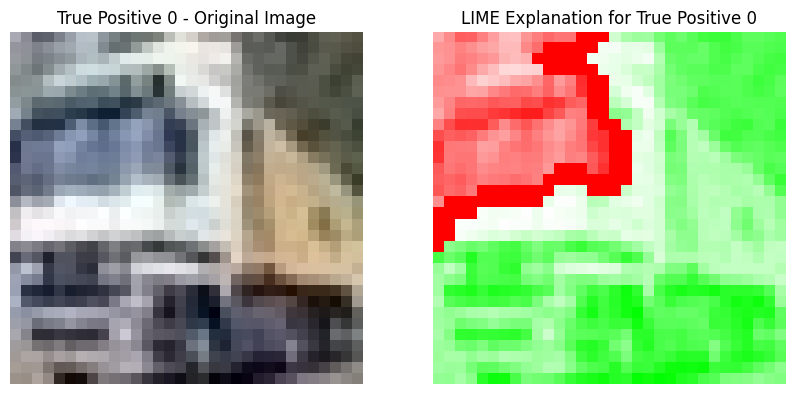

Generating LIME for True Positive 1


  0%|          | 0/50 [00:00<?, ?it/s]


Explanation for True Positive 1:

Feature 0: (0, 0.007324193469062476)


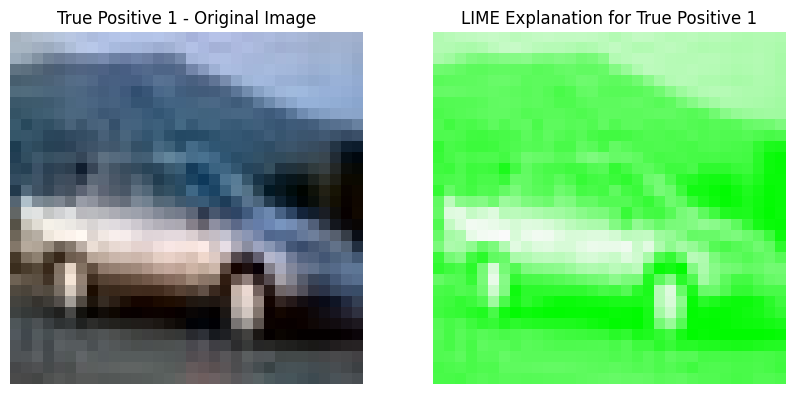

Generating LIME for True Positive 2


  0%|          | 0/50 [00:00<?, ?it/s]


Explanation for True Positive 2:

Feature 0: (0, 0.00930161261954191)


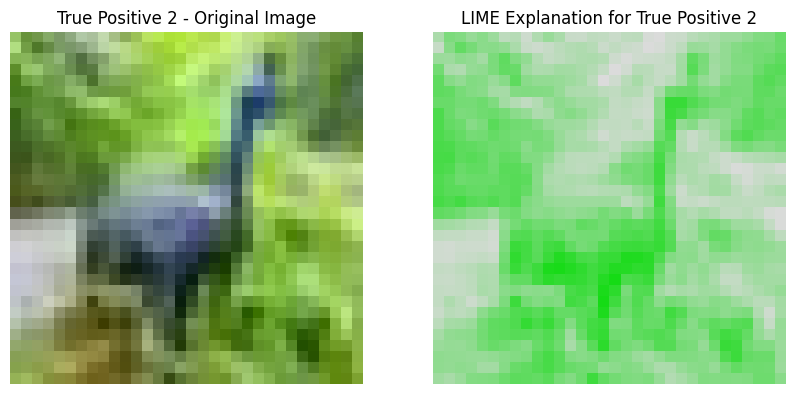

Generating LIME for False Positive 0


  0%|          | 0/50 [00:00<?, ?it/s]


Explanation for False Positive 0:

Feature 0: (1, 0.7556075204528762)
Feature 1: (0, 0.7366786968395708)


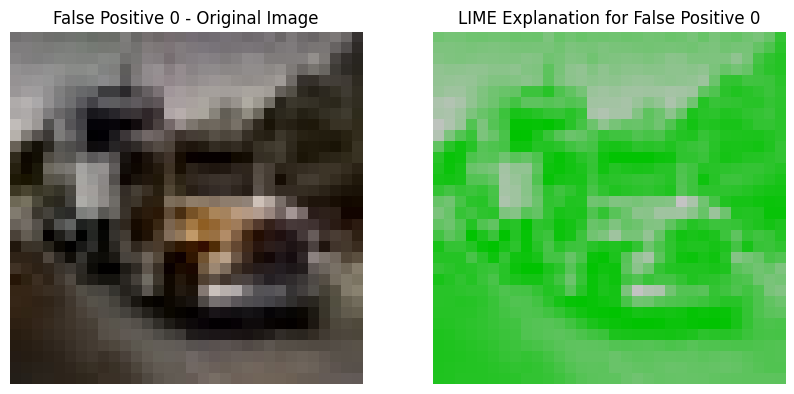

Generating LIME for False Positive 1


  0%|          | 0/50 [00:00<?, ?it/s]


Explanation for False Positive 1:

Feature 0: (1, 0.8315553454954068)
Feature 1: (0, -0.05604933693555004)


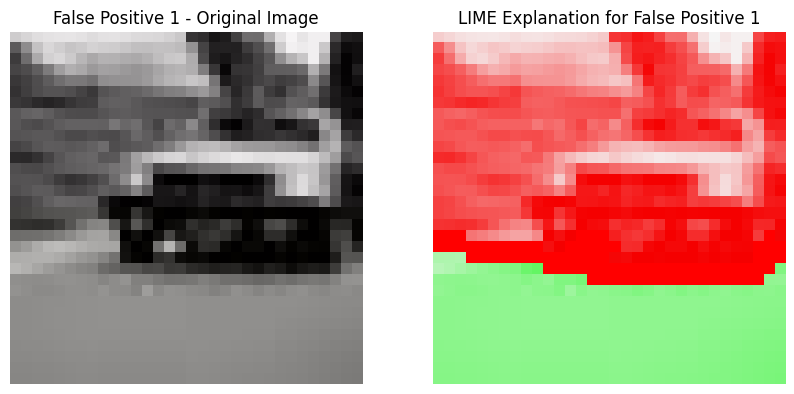

Generating LIME for False Positive 2


  0%|          | 0/50 [00:00<?, ?it/s]


Explanation for False Positive 2:

Feature 0: (0, 0.0)


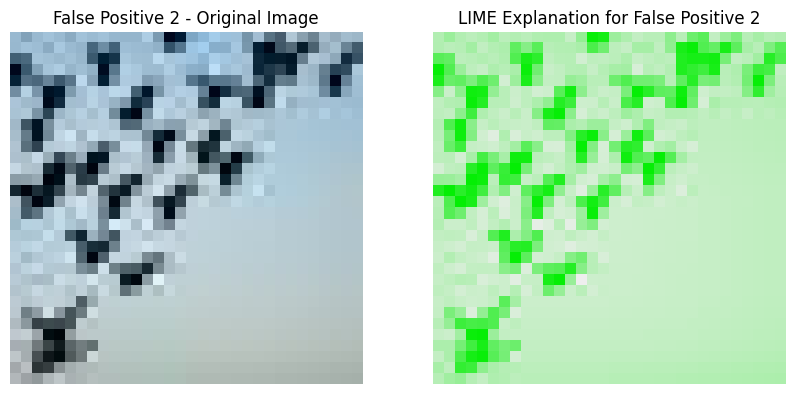

Generating LIME for False Negative 0


  0%|          | 0/50 [00:00<?, ?it/s]


Explanation for False Negative 0:

Feature 0: (0, 0.008972687438272637)


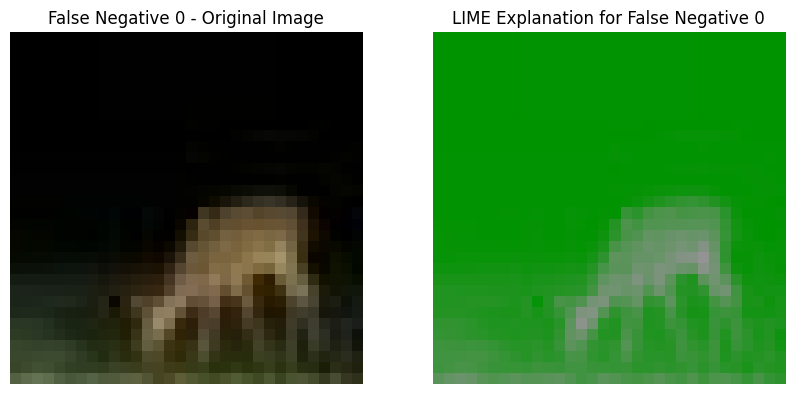

Applying LIME to Test Dataset...
Generating LIME for True Positive 0


  0%|          | 0/50 [00:00<?, ?it/s]


Explanation for True Positive 0:

Feature 0: (0, 0.007324193469062476)


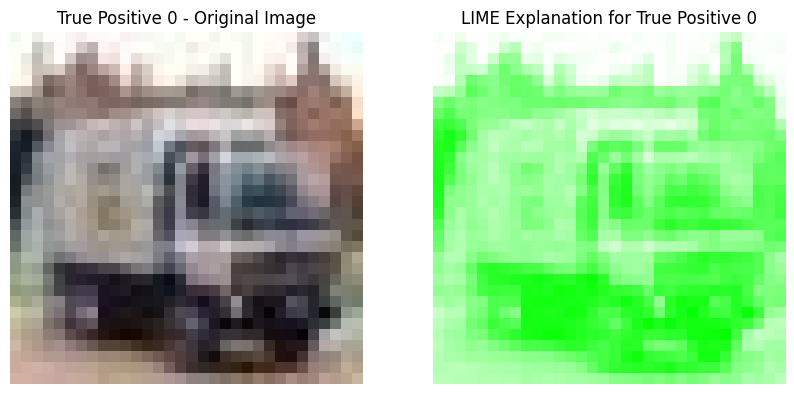

Generating LIME for True Positive 1


  0%|          | 0/50 [00:00<?, ?it/s]


Explanation for True Positive 1:

Feature 0: (0, 0.0)


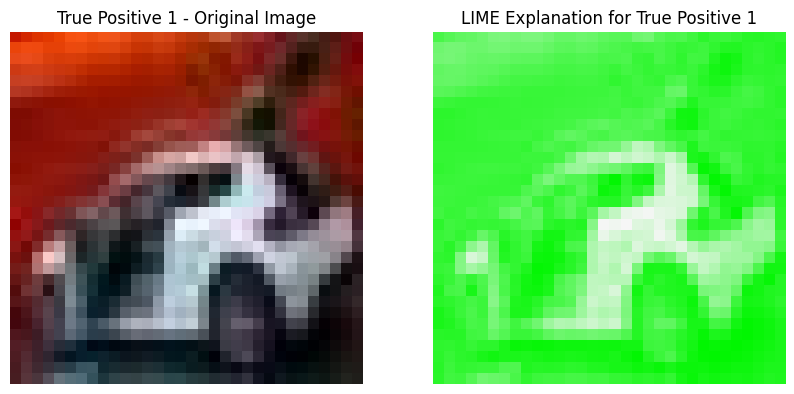

Generating LIME for True Positive 2


  0%|          | 0/50 [00:00<?, ?it/s]


Explanation for True Positive 2:

Feature 0: (0, 0.006332128349850763)


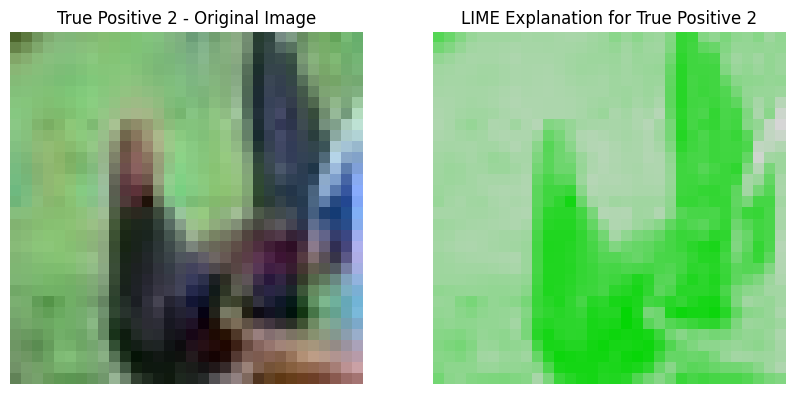

Generating LIME for False Positive 0


  0%|          | 0/50 [00:00<?, ?it/s]


Explanation for False Positive 0:

Feature 0: (0, 0.7848363916057122)
Feature 1: (1, 0.7474713648140501)


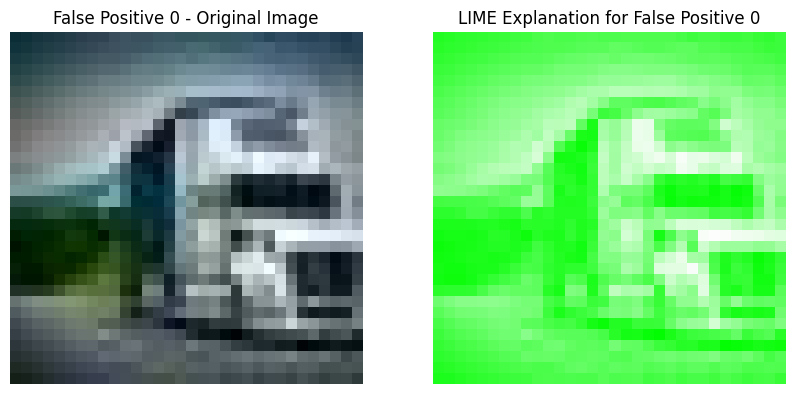

Generating LIME for False Positive 1


  0%|          | 0/50 [00:00<?, ?it/s]


Explanation for False Positive 1:

Feature 0: (0, 0.0)


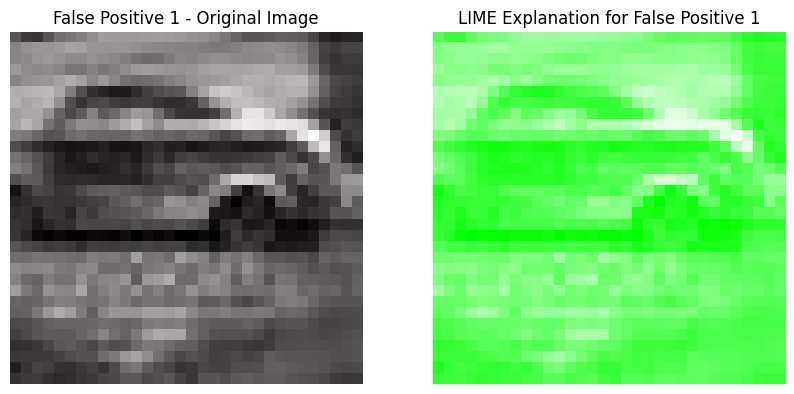

Generating LIME for False Positive 2


  0%|          | 0/50 [00:00<?, ?it/s]


Explanation for False Positive 2:

Feature 0: (0, 0.0)
Feature 1: (1, 0.0)


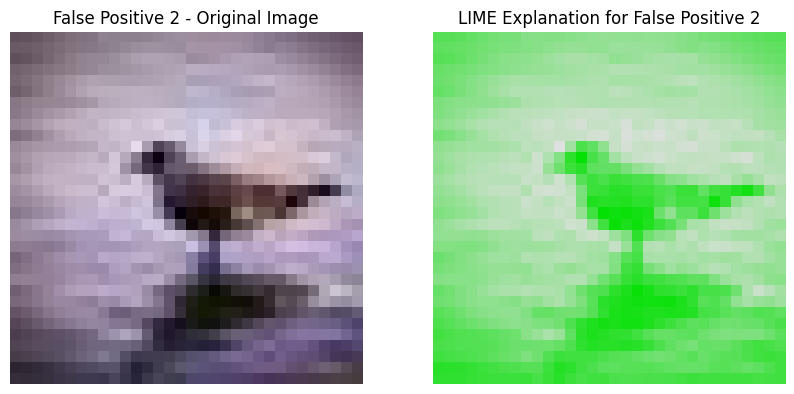

Generating LIME for False Negative 0


  0%|          | 0/50 [00:00<?, ?it/s]


Explanation for False Negative 0:

Feature 0: (0, 0.007324193469062475)


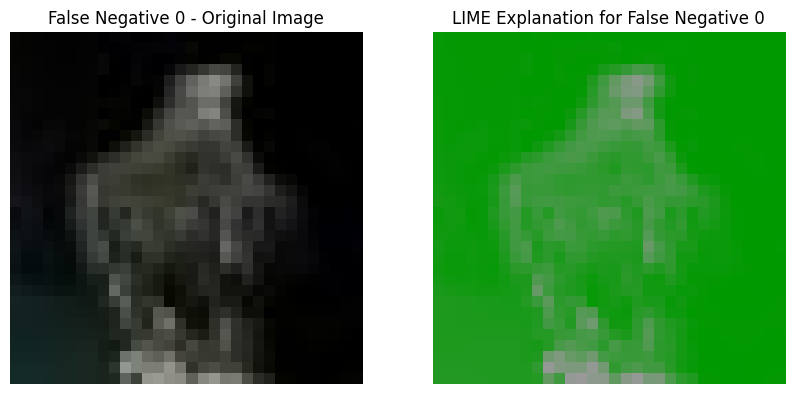

In [10]:
import lime
import lime.lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
from sklearn.tree import DecisionTreeClassifier

# Redefine the predict_proba function for LIME to predict using the Decision Tree model
def predict_proba_fn(images):
    # Extract features for each image in the batch
    features = np.array([extract_features(image) for image in images])
    features = scaler.transform(features)  # Scale the features using the fitted scaler
    return decision_tree.predict_proba(features)  # Use the Decision Tree model to predict probabilities

# Initialize LIME explainer for images
explainer = lime.lime_image.LimeImageExplainer()

# Load original images for X_test (before feature extraction)
def load_images(base_path):
    images, labels = [], []
    for label in ['real', 'fake']:
        folder_path = os.path.join(base_path, label)
        for image_name in os.listdir(folder_path):
            image_path = os.path.join(folder_path, image_name)
            image = cv2.imread(image_path)
            images.append(image)
            labels.append(1 if label == 'real' else 0)  # 1 for real, 0 for fake
    return np.array(images), np.array(labels)

# Function to classify images into TP, TN, FP, FN
def classify_images(y_true, y_pred):
    tp = np.where((y_true == 1) & (y_pred == 1))[0]  # True Positives
    tn = np.where((y_true == 0) & (y_pred == 0))[0]  # True Negatives
    fp = np.where((y_true == 0) & (y_pred == 1))[0]  # False Positives
    fn = np.where((y_true == 1) & (y_pred == 0))[0]  # False Negatives
    return tp, tn, fp, fn

# Apply LIME to test dataset with original images and visualize TP, TN, FP, FN
def apply_lime_to_dataset(images, labels, dataset_type='Test'):
    # Predict the labels using the classifier (for classification of TP, TN, FP, FN)
    y_pred = decision_tree.predict([extract_features(image) for image in images])
    
    tp, tn, fp, fn = classify_images(labels, y_pred)
    
    # Limit to 3 images per classification
    tp = tp[:3]
    tn = tn[:3]
    fp = fp[:3]
    fn = fn[:3]
    
    # Create the folder structure for saving images
    output_folder = f"lime_decision_tree/{dataset_type}"
    os.makedirs(output_folder, exist_ok=True)

    # Save and display the LIME explanations for each classification type
    for i, idx in enumerate(tp):
        print(f"Generating LIME for True Positive {i}")
        save_and_display_lime(images[idx], f"True Positive {i}", output_folder)
    
    for i, idx in enumerate(tn):
        print(f"Generating LIME for True Negative {i}")
        save_and_display_lime(images[idx], f"True Negative {i}", output_folder)
    
    for i, idx in enumerate(fp):
        print(f"Generating LIME for False Positive {i}")
        save_and_display_lime(images[idx], f"False Positive {i}", output_folder)
    
    for i, idx in enumerate(fn):
        print(f"Generating LIME for False Negative {i}")
        save_and_display_lime(images[idx], f"False Negative {i}", output_folder)

# Function to generate LIME explanations, visualize, and display in console as well as save them
def save_and_display_lime(image, label, output_folder):
    # Convert to grayscale for explanation
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Generate explanation for the instance
    explanation = explainer.explain_instance(
        image=gray_image,          # Pass the grayscale image
        classifier_fn=predict_proba_fn,  # Prediction function using Decision Tree model
        top_labels=2,               # Number of top labels to explain
        hide_color=0,               # Color to hide areas (black in this case)
        num_samples=50            # Number of perturbations LIME will generate
    )

    # Display explanation in console
    print(f"\nExplanation for {label}:\n")
    for i, feature in enumerate(explanation.local_exp[explanation.top_labels[0]]):
        print(f"Feature {i}: {feature}")

    # Visualize the explanation with boundaries
    temp, mask = explanation.get_image_and_mask(
        explanation.top_labels[0],  # Label to explain
        positive_only=False,        # Show both positive and negative contributions
        num_features=10,            # Number of superpixels (features) to show
        hide_rest=False             # Show the entire image
    )

    # Prepare filenames
    original_image_filename = os.path.join(output_folder, f"{label}_original.jpg")
    lime_image_filename = os.path.join(output_folder, f"{label}_lime.jpg")

    # Plot and save the original image with LIME explanation
    plt.figure(figsize=(10, 10))

    # Display original image
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(f'{label} - Original Image')
    plt.axis('off')  # Turn off axis

    # Display LIME explanation with boundaries
    plt.subplot(1, 2, 2)
    plt.imshow(mark_boundaries(temp, mask, color=(1, 0, 0), mode='thick'))
    plt.title(f'LIME Explanation for {label}')
    plt.axis('off')  # Turn off axis

    # Save the plot
    plt.savefig(lime_image_filename)
    
    # Show the image in the console (pop-up window)
    plt.show()  # This will pop up the image in a GUI window
    
    # Close the plot window
    plt.close()

# Load original train and test images (before feature extraction)
base_path_train = r"C:\Desktop\ML_Implementation\data(Final_ML)\train"
base_path_test = r"C:\Desktop\ML_Implementation\data(Final_ML)\test"

image_train, y_train = load_images(base_path_train)
image_test, y_test = load_images(base_path_test)

# Apply LIME to the train dataset (True Positive, True Negative, False Positive, False Negative)
print("Applying LIME to Train Dataset...")
apply_lime_to_dataset(image_train, y_train, dataset_type='train')

# Apply LIME to the test dataset (True Positive, True Negative, False Positive, False Negative)
print("Applying LIME to Test Dataset...")
apply_lime_to_dataset(image_test, y_test, dataset_type='test')


In [11]:
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Initialize the Random Forest Classifier with chosen parameters
random_forest = RandomForestClassifier(n_estimators=200, max_depth=20, random_state=42)

# Fit the model to the training data
random_forest.fit(X_train, y_train)

# Make predictions on the test set
y_pred = random_forest.predict(X_test)

# Performance Metrics
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Create a directory for saving the results if it doesn't exist
output_folder = "randomforest_class"
os.makedirs(output_folder, exist_ok=True)

# Save the classification report to a text file
report_filename = os.path.join(output_folder, "classification_report.txt")
with open(report_filename, "w") as f:
    f.write(report)

# Save the confusion matrix to a text file
conf_matrix_filename = os.path.join(output_folder, "confusion_matrix.txt")
with open(conf_matrix_filename, "w") as f:
    f.write(str(conf_matrix))

# Optionally print the results in the console
print("Classification Report:")
print(report)
print("Confusion Matrix:")
print(conf_matrix)

print("saved")

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.76      0.77       965
           1       0.81      0.82      0.82      1220

    accuracy                           0.79      2185
   macro avg       0.79      0.79      0.79      2185
weighted avg       0.79      0.79      0.79      2185

Confusion Matrix:
[[ 734  231]
 [ 219 1001]]
saved


Applying LIME to Train Dataset...
Generating LIME for True Positive 0


  0%|          | 0/50 [00:00<?, ?it/s]


Explanation for True Positive 0:

Feature 0: (1, 0.28909346583681056)
Feature 1: (0, 0.2546613131845398)


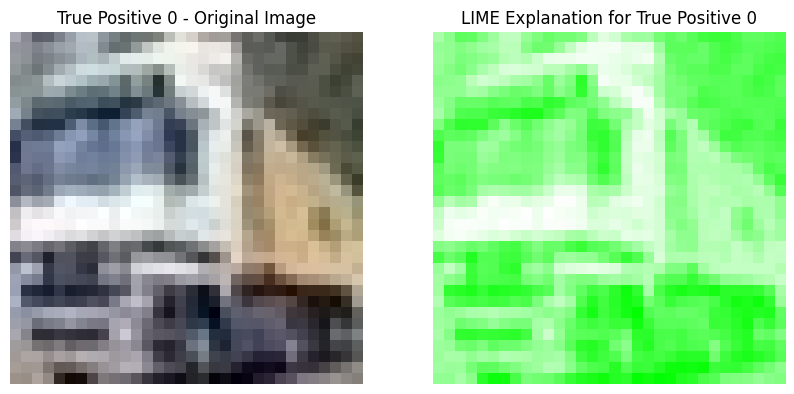

Generating LIME for True Positive 1


  0%|          | 0/50 [00:00<?, ?it/s]


Explanation for True Positive 1:

Feature 0: (0, 0.003452209340024524)


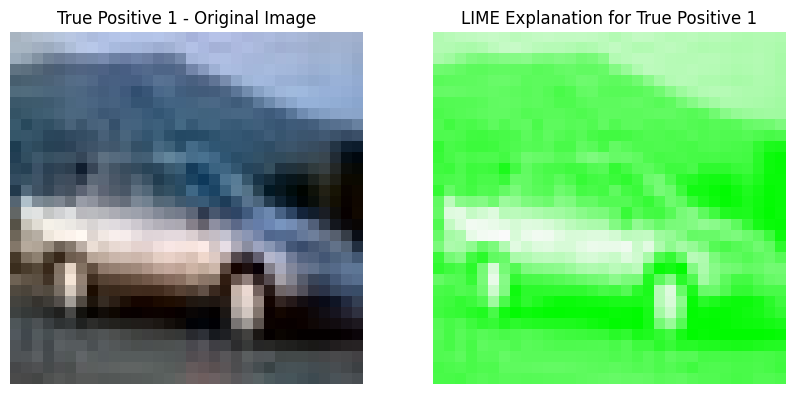

Generating LIME for True Positive 2


  0%|          | 0/50 [00:00<?, ?it/s]


Explanation for True Positive 2:

Feature 0: (0, 0.004348322880199325)


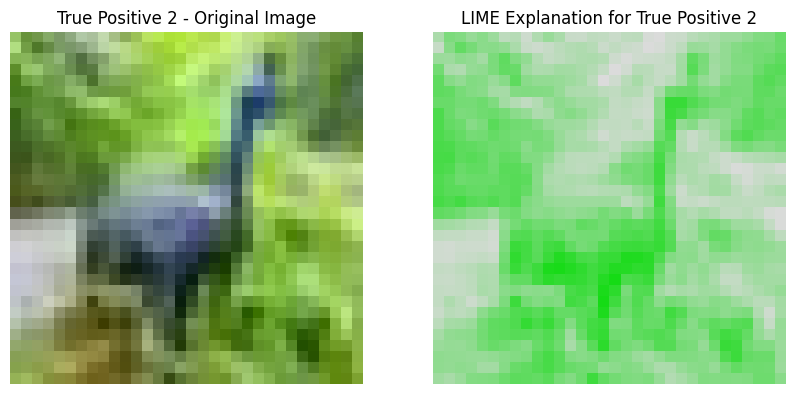

Generating LIME for False Positive 0


  0%|          | 0/50 [00:00<?, ?it/s]


Explanation for False Positive 0:

Feature 0: (1, 0.24185730326874713)
Feature 1: (0, 0.1134720762819542)


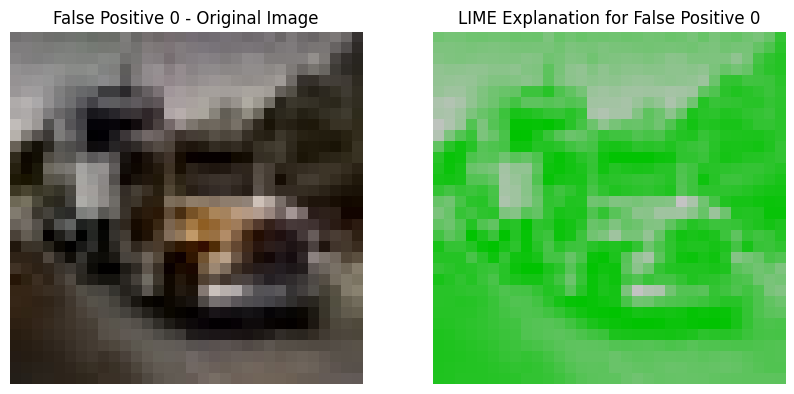

Generating LIME for False Positive 1


  0%|          | 0/50 [00:00<?, ?it/s]


Explanation for False Positive 1:

Feature 0: (0, 0.29462798770767673)
Feature 1: (1, 0.03525082710726613)


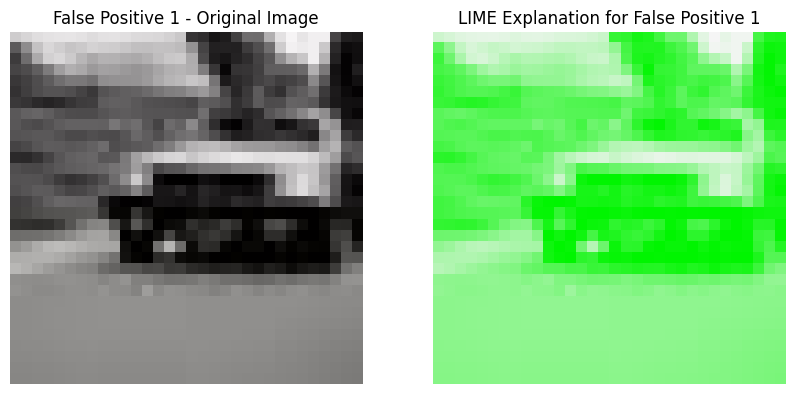

Generating LIME for False Positive 2


  0%|          | 0/50 [00:00<?, ?it/s]


Explanation for False Positive 2:

Feature 0: (0, 0.0034285535485174988)


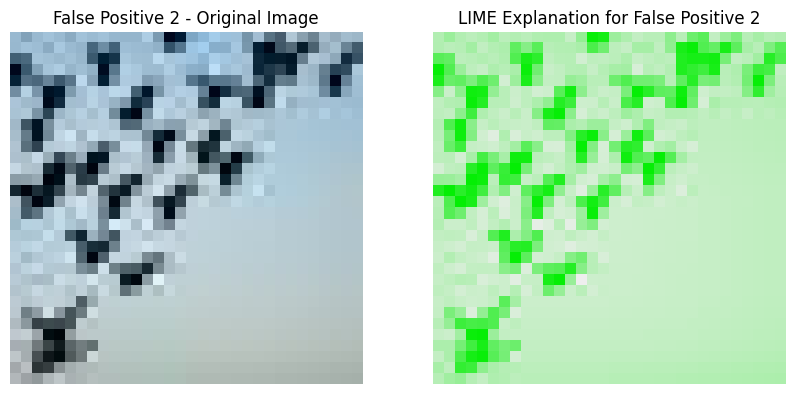

Generating LIME for False Negative 0


  0%|          | 0/50 [00:00<?, ?it/s]


Explanation for False Negative 0:

Feature 0: (0, 0.0037257484506370005)


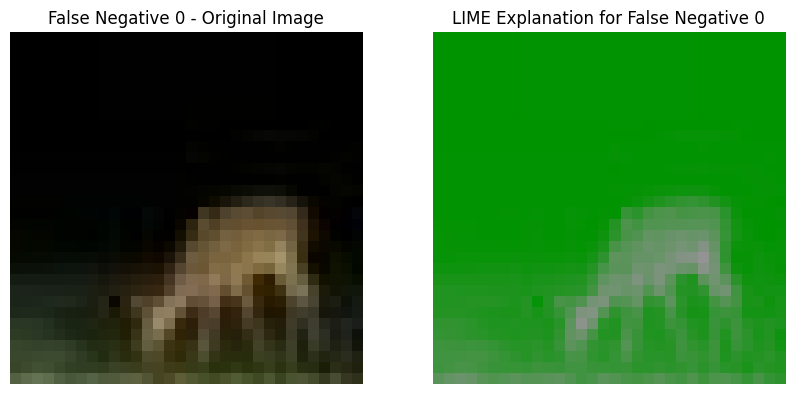

Applying LIME to Test Dataset...
Generating LIME for True Positive 0


  0%|          | 0/50 [00:00<?, ?it/s]


Explanation for True Positive 0:

Feature 0: (0, 0.002098770957676969)


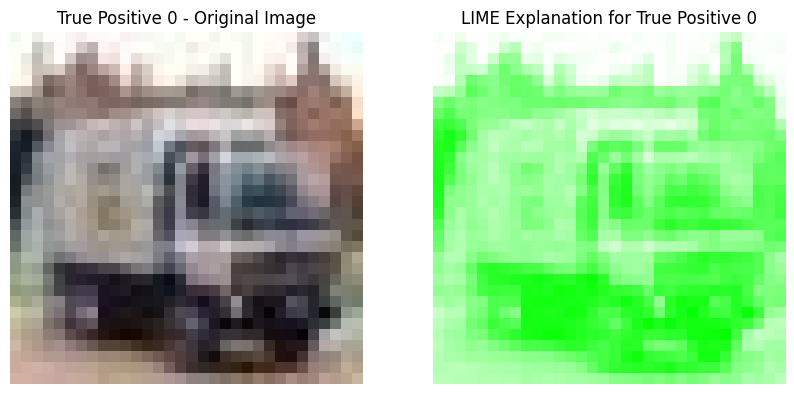

Generating LIME for True Positive 1


  0%|          | 0/50 [00:00<?, ?it/s]


Explanation for True Positive 1:

Feature 0: (0, 0.0009342129270206839)


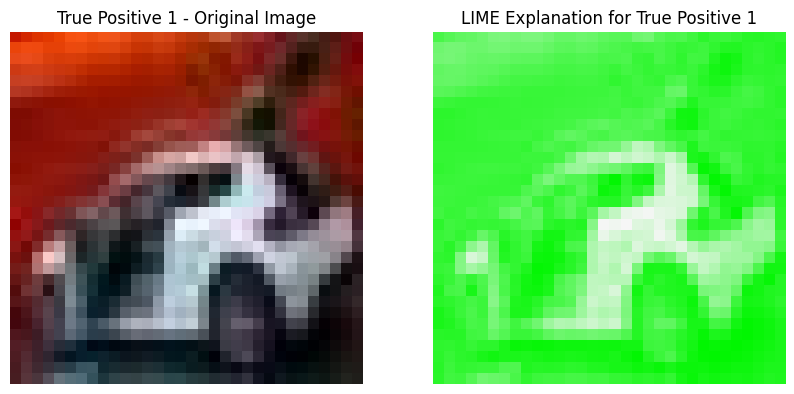

Generating LIME for True Positive 2


  0%|          | 0/50 [00:00<?, ?it/s]


Explanation for True Positive 2:

Feature 0: (0, 0.0020025623400656985)


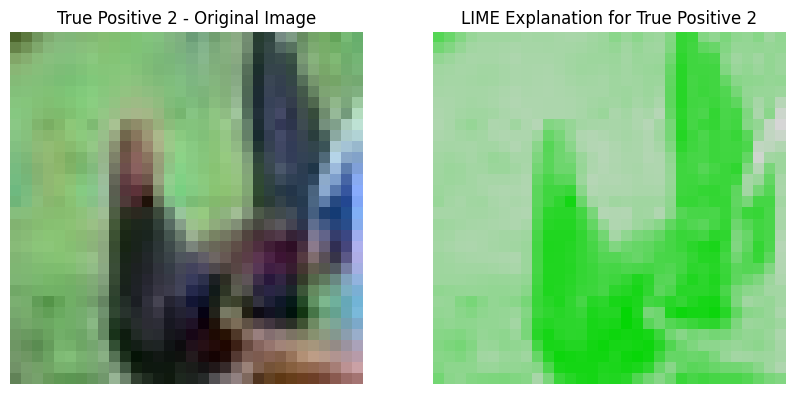

Generating LIME for False Positive 0


  0%|          | 0/50 [00:00<?, ?it/s]


Explanation for False Positive 0:

Feature 0: (1, 0.12205091338641519)
Feature 1: (0, 0.11679747487686336)


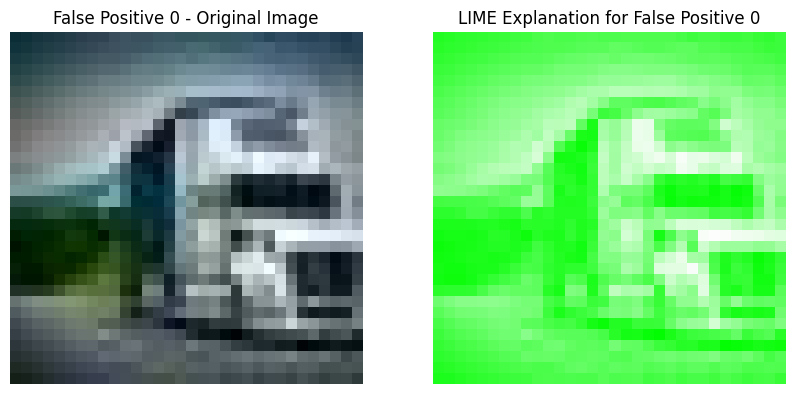

Generating LIME for False Positive 1


  0%|          | 0/50 [00:00<?, ?it/s]


Explanation for False Positive 1:

Feature 0: (0, 0.0031742932048888827)


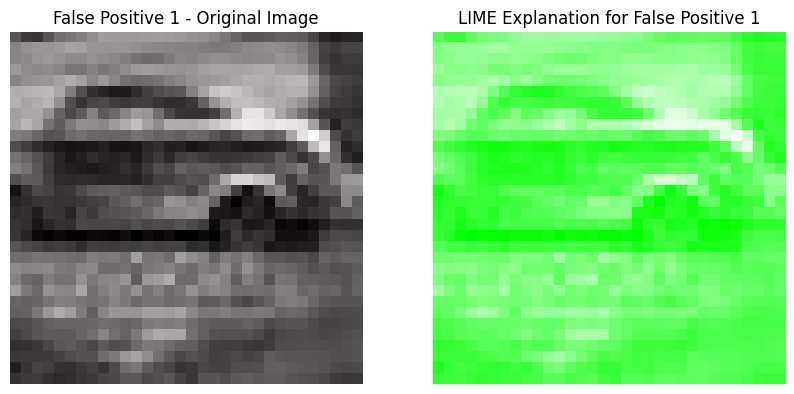

Generating LIME for False Positive 2


  0%|          | 0/50 [00:00<?, ?it/s]


Explanation for False Positive 2:

Feature 0: (0, 0.11225564656472009)
Feature 1: (1, 0.039731718346675625)


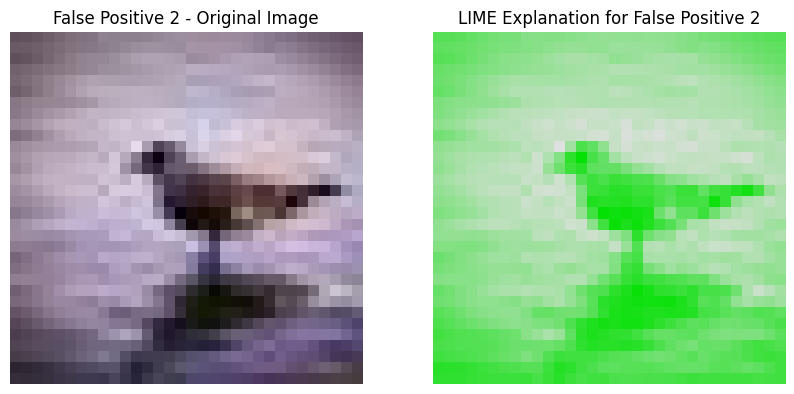

In [12]:
import lime
import lime.lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
from sklearn.ensemble import RandomForestClassifier

# Redefine the predict_proba function for LIME to predict using the Random Forest model
def predict_proba_fn(images):
    # Extract features for each image in the batch
    features = np.array([extract_features(image) for image in images])
    features = scaler.transform(features)  # Scale the features using the fitted scaler
    return random_forest.predict_proba(features)  # Use the Random Forest model to predict probabilities

# Initialize LIME explainer for images
explainer = lime.lime_image.LimeImageExplainer()

# Load original images for X_test (before feature extraction)
def load_images(base_path):
    images, labels = [], []
    for label in ['real', 'fake']:
        folder_path = os.path.join(base_path, label)
        for image_name in os.listdir(folder_path):
            image_path = os.path.join(folder_path, image_name)
            image = cv2.imread(image_path)
            images.append(image)
            labels.append(1 if label == 'real' else 0)  # 1 for real, 0 for fake
    return np.array(images), np.array(labels)

# Function to classify images into TP, TN, FP, FN
def classify_images(y_true, y_pred):
    tp = np.where((y_true == 1) & (y_pred == 1))[0]  # True Positives
    tn = np.where((y_true == 0) & (y_pred == 0))[0]  # True Negatives
    fp = np.where((y_true == 0) & (y_pred == 1))[0]  # False Positives
    fn = np.where((y_true == 1) & (y_pred == 0))[0]  # False Negatives
    return tp, tn, fp, fn

# Apply LIME to test dataset with original images and visualize TP, TN, FP, FN
def apply_lime_to_dataset(images, labels, dataset_type='Test'):
    # Predict the labels using the classifier (for classification of TP, TN, FP, FN)
    y_pred = random_forest.predict([extract_features(image) for image in images])
    
    tp, tn, fp, fn = classify_images(labels, y_pred)
    
    # Limit to 3 images per classification
    tp = tp[:3]
    tn = tn[:3]
    fp = fp[:3]
    fn = fn[:3]
    
    # Create the folder structure for saving images
    output_folder = f"lime_random_forest/{dataset_type}"
    os.makedirs(output_folder, exist_ok=True)

    # Save and display the LIME explanations for each classification type
    for i, idx in enumerate(tp):
        print(f"Generating LIME for True Positive {i}")
        save_and_display_lime(images[idx], f"True Positive {i}", output_folder)
    
    for i, idx in enumerate(tn):
        print(f"Generating LIME for True Negative {i}")
        save_and_display_lime(images[idx], f"True Negative {i}", output_folder)
    
    for i, idx in enumerate(fp):
        print(f"Generating LIME for False Positive {i}")
        save_and_display_lime(images[idx], f"False Positive {i}", output_folder)
    
    for i, idx in enumerate(fn):
        print(f"Generating LIME for False Negative {i}")
        save_and_display_lime(images[idx], f"False Negative {i}", output_folder)

# Function to generate LIME explanations, visualize, and display in console as well as save them
def save_and_display_lime(image, label, output_folder):
    # Convert to grayscale for explanation
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Generate explanation for the instance
    explanation = explainer.explain_instance(
        image=gray_image,          # Pass the grayscale image
        classifier_fn=predict_proba_fn,  # Prediction function using Random Forest model
        top_labels=2,               # Number of top labels to explain
        hide_color=0,               # Color to hide areas (black in this case)
        num_samples=50            # Number of perturbations LIME will generate
    )

    # Display explanation in console
    print(f"\nExplanation for {label}:\n")
    for i, feature in enumerate(explanation.local_exp[explanation.top_labels[0]]):
        print(f"Feature {i}: {feature}")

    # Visualize the explanation with boundaries
    temp, mask = explanation.get_image_and_mask(
        explanation.top_labels[0],  # Label to explain
        positive_only=False,        # Show both positive and negative contributions
        num_features=10,            # Number of superpixels (features) to show
        hide_rest=False             # Show the entire image
    )

    # Prepare filenames
    original_image_filename = os.path.join(output_folder, f"{label}_original.jpg")
    lime_image_filename = os.path.join(output_folder, f"{label}_lime.jpg")

    # Plot and save the original image with LIME explanation
    plt.figure(figsize=(10, 10))

    # Display original image
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(f'{label} - Original Image')
    plt.axis('off')  # Turn off axis

    # Display LIME explanation with boundaries
    plt.subplot(1, 2, 2)
    plt.imshow(mark_boundaries(temp, mask, color=(1, 0, 0), mode='thick'))
    plt.title(f'LIME Explanation for {label}')
    plt.axis('off')  # Turn off axis

    # Save the plot
    plt.savefig(lime_image_filename)
    
    # Show the image in the console (pop-up window)
    plt.show()  # This will pop up the image in a GUI window
    
    # Close the plot window
    plt.close()

# Load original train and test images (before feature extraction)
base_path_train = r"C:\Desktop\ML_Implementation\data(Final_ML)\train"
base_path_test = r"C:\Desktop\ML_Implementation\data(Final_ML)\test"

image_train, y_train = load_images(base_path_train)
image_test, y_test = load_images(base_path_test)

# Apply LIME to the train dataset (True Positive, True Negative, False Positive, False Negative)
print("Applying LIME to Train Dataset...")
apply_lime_to_dataset(image_train, y_train, dataset_type='train')

# Apply LIME to the test dataset (True Positive, True Negative, False Positive, False Negative)
print("Applying LIME to Test Dataset...")
apply_lime_to_dataset(image_test, y_test, dataset_type='test')


In [13]:
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, confusion_matrix
import joblib

# Initialize the CatBoost Classifier
catboost_model = CatBoostClassifier(iterations=1000, depth=6, learning_rate=0.1, random_seed=42, verbose=0)

# Fit the model to the training data
catboost_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = catboost_model.predict(X_test)

# Generate performance metrics
classification_rep = classification_report(y_test, y_pred)
confusion_mat = confusion_matrix(y_test, y_pred)

# Save results as attributes in the model
catboost_model.classification_report_ = classification_rep
catboost_model.confusion_matrix_ = confusion_mat

# Print performance metrics
print("Classification Report:\n", classification_rep)
print("Confusion Matrix:\n", confusion_mat)

# Optionally, you can save the model with the added metrics using joblib
joblib.dump(catboost_model, 'catboost_model_with_metrics.pkl')
joblib.dump(scaler, 'scaler.pkl')

# Now, the metrics are stored in the model and can be accessed later like this:
# catboost_model.classification_report_
# catboost_model.confusion_matrix_


Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.82      0.82       965
           1       0.85      0.85      0.85      1220

    accuracy                           0.84      2185
   macro avg       0.83      0.83      0.83      2185
weighted avg       0.84      0.84      0.84      2185

Confusion Matrix:
 [[ 787  178]
 [ 178 1042]]


['scaler.pkl']

In [14]:
from catboost import CatBoostClassifier
# Initialize the CatBoost Classifier
catboost_model = CatBoostClassifier(iterations=1000, depth=6, learning_rate=0.1, random_seed=42, verbose=0)

# Fit the model to the training data
catboost_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = catboost_model.predict(X_test)

# Performance Metrics
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

# Performance metrics
class_report = classification_report(y_test, y_pred, output_dict=True)
conf_matrix = confusion_matrix(y_test, y_pred)

# Print performance metrics
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", conf_matrix)

# Convert classification report to DataFrame
class_report_df = pd.DataFrame(class_report).transpose()

# Convert confusion matrix to DataFrame
conf_matrix_df = pd.DataFrame(conf_matrix, columns=['Predicted fake', 'Predicted Real'], index=['Actual fake', 'Actual Real'])

# Convert predicted probabilities to DataFrame
y_prob_df = pd.DataFrame(y_prob, columns=[f'Prob_0', f'Prob_1'])

# Save results to Excel
with pd.ExcelWriter('catboost_predict_results.xlsx') as writer:
    class_report_df.to_excel(writer, sheet_name='Classification Report')
    conf_matrix_df.to_excel(writer, sheet_name='Confusion Matrix')
    y_prob_df.to_excel(writer, sheet_name='Predicted Probabilities')

print("Results have been saved to 'catboost_predict_results.xlsx'")

              precision    recall  f1-score   support

           0       0.82      0.82      0.82       965
           1       0.85      0.85      0.85      1220

    accuracy                           0.84      2185
   macro avg       0.83      0.83      0.83      2185
weighted avg       0.84      0.84      0.84      2185

[[ 787  178]
 [ 178 1042]]
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.82      0.82       965
           1       0.85      0.85      0.85      1220

    accuracy                           0.84      2185
   macro avg       0.83      0.83      0.83      2185
weighted avg       0.84      0.84      0.84      2185

Confusion Matrix:
 [[ 787  178]
 [ 178 1042]]
Results have been saved to 'catboost_predict_results.xlsx'


Applying LIME to Train Dataset...
Generating LIME for True Positive 0


  0%|          | 0/50 [00:00<?, ?it/s]


Explanation for True Positive 0:

Feature 0: (1, 0.0005803407487753923)
Feature 1: (0, -2.3739577053923414e-05)


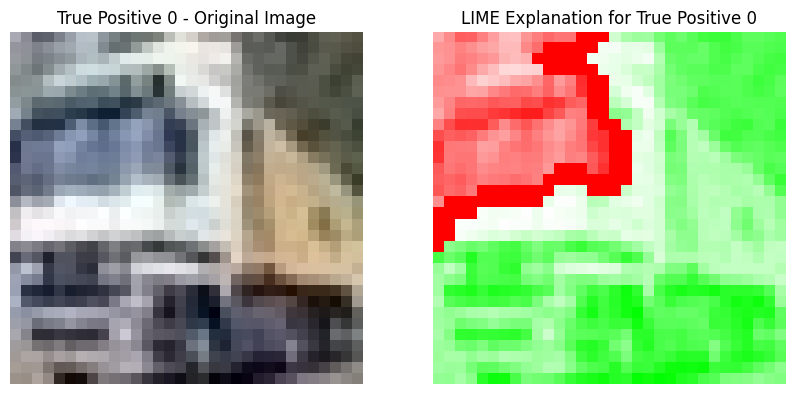

Generating LIME for True Positive 1


  0%|          | 0/50 [00:00<?, ?it/s]


Explanation for True Positive 1:

Feature 0: (0, 0.00029624428363720664)


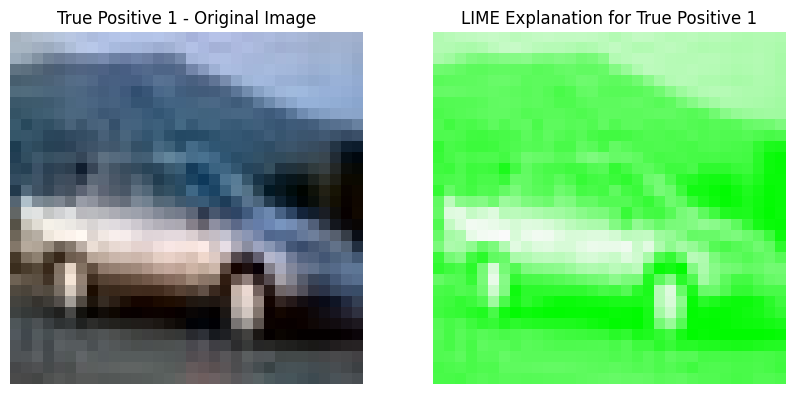

Generating LIME for True Positive 2


  0%|          | 0/50 [00:00<?, ?it/s]


Explanation for True Positive 2:

Feature 0: (0, 0.0002948742592769318)


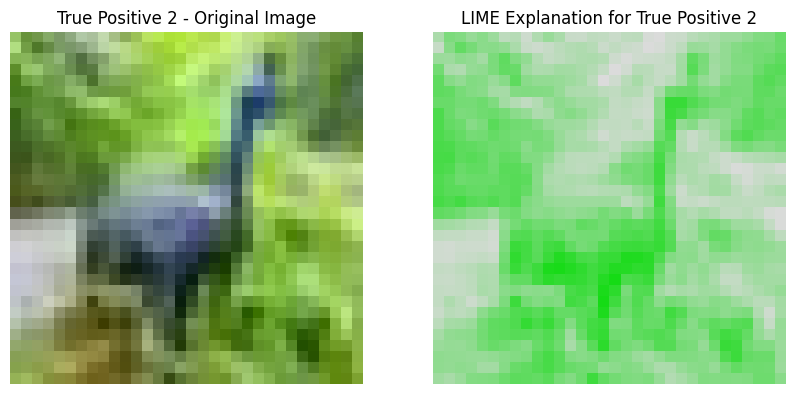

Generating LIME for True Negative 0


  0%|          | 0/50 [00:00<?, ?it/s]


Explanation for True Negative 0:

Feature 0: (1, -0.0007626219048817833)
Feature 1: (0, 0.00010812709954397581)


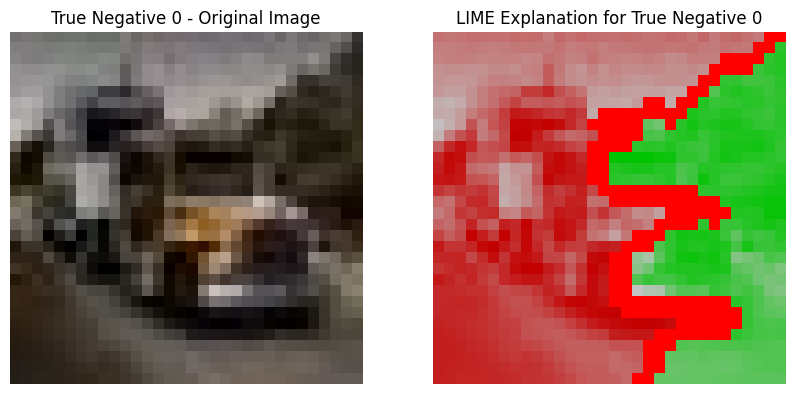

Generating LIME for True Negative 1


  0%|          | 0/50 [00:00<?, ?it/s]


Explanation for True Negative 1:

Feature 0: (1, -0.0005102658117033714)
Feature 1: (0, -4.9599810836883114e-05)


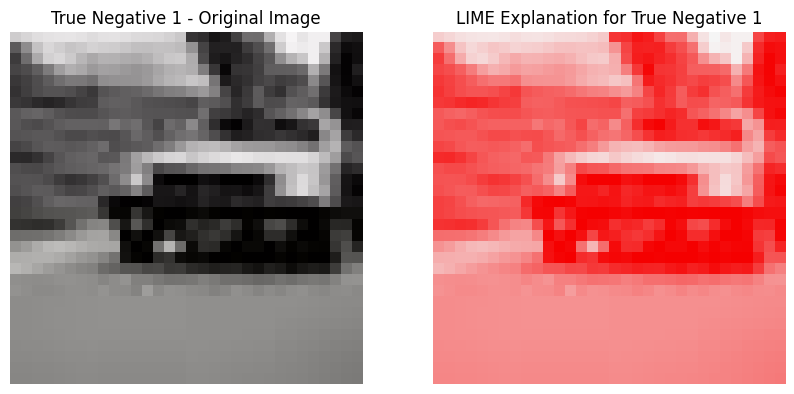

Generating LIME for True Negative 2


  0%|          | 0/50 [00:00<?, ?it/s]


Explanation for True Negative 2:

Feature 0: (0, 0.00039500767385732515)


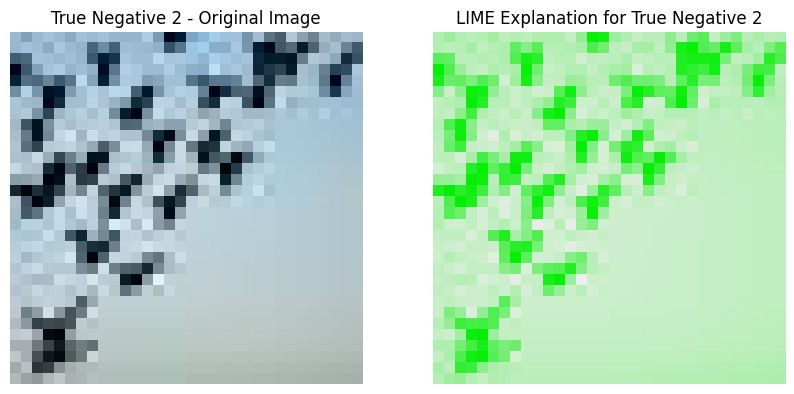

Applying LIME to Test Dataset...
Generating LIME for True Positive 0


  0%|          | 0/50 [00:00<?, ?it/s]


Explanation for True Positive 0:

Feature 0: (0, 0.00023787532452857783)


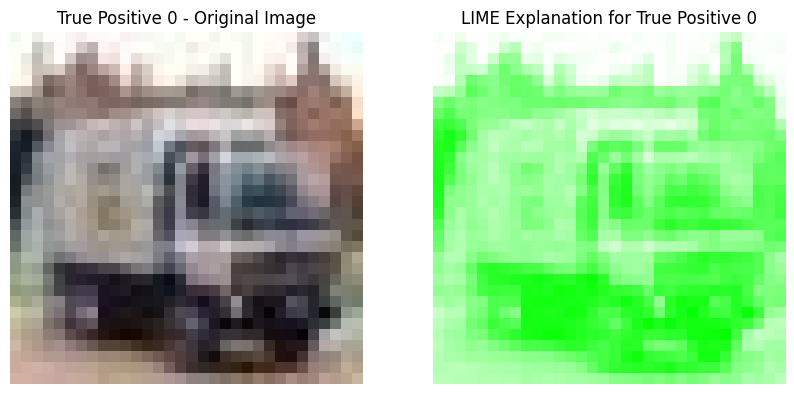

Generating LIME for True Positive 1


  0%|          | 0/50 [00:00<?, ?it/s]


Explanation for True Positive 1:

Feature 0: (0, 0.00030108350828711195)


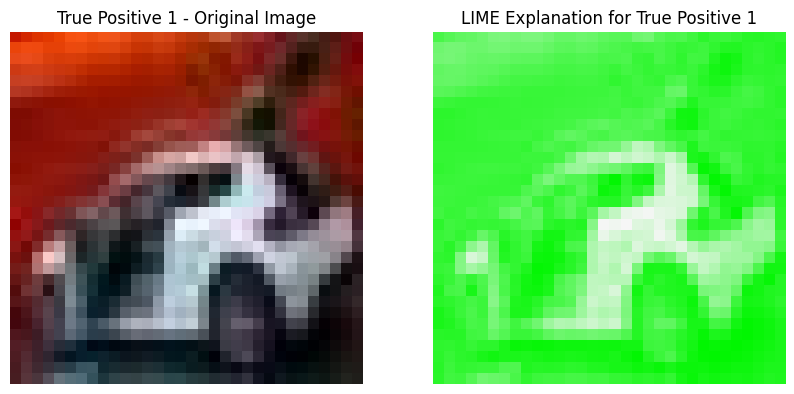

Generating LIME for True Positive 2


  0%|          | 0/50 [00:00<?, ?it/s]


Explanation for True Positive 2:

Feature 0: (0, 0.00031133413948896413)


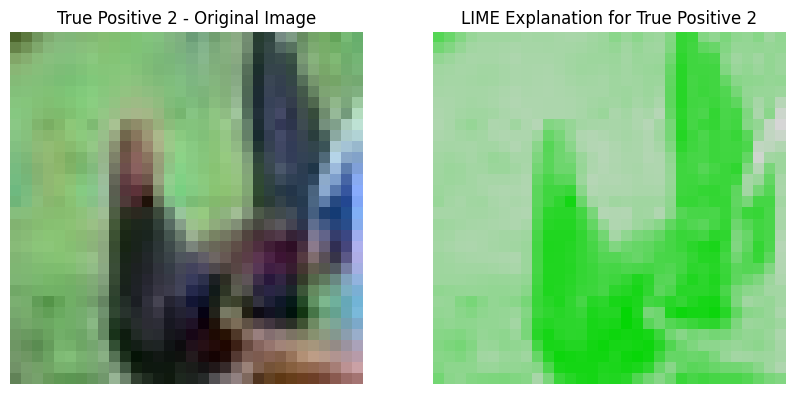

Generating LIME for True Negative 0


  0%|          | 0/50 [00:00<?, ?it/s]


Explanation for True Negative 0:

Feature 0: (1, -0.0008894182585974068)
Feature 1: (0, -0.0006291970914569703)


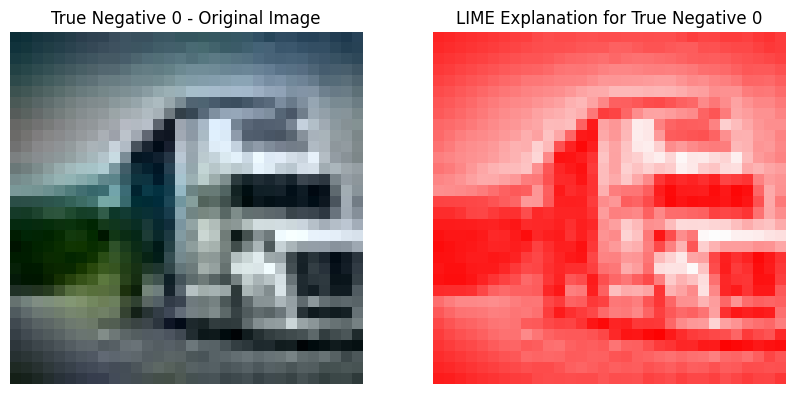

Generating LIME for True Negative 1


  0%|          | 0/50 [00:00<?, ?it/s]


Explanation for True Negative 1:

Feature 0: (0, 0.00044922795231627305)


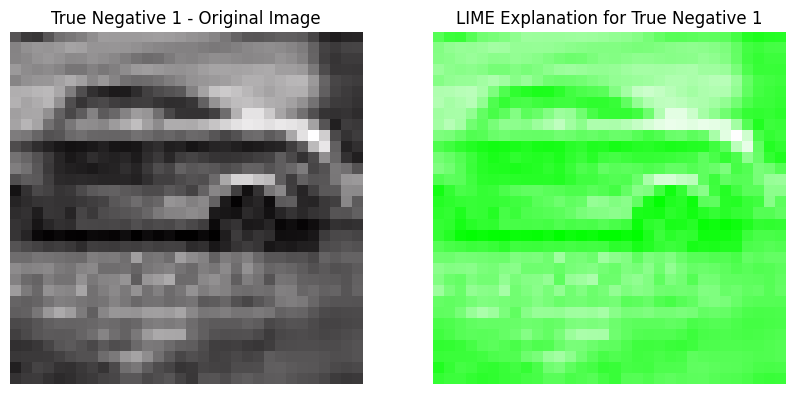

Generating LIME for True Negative 2


  0%|          | 0/50 [00:00<?, ?it/s]


Explanation for True Negative 2:

Feature 0: (1, 0.006601609198215663)
Feature 1: (0, 0.003383641725278754)


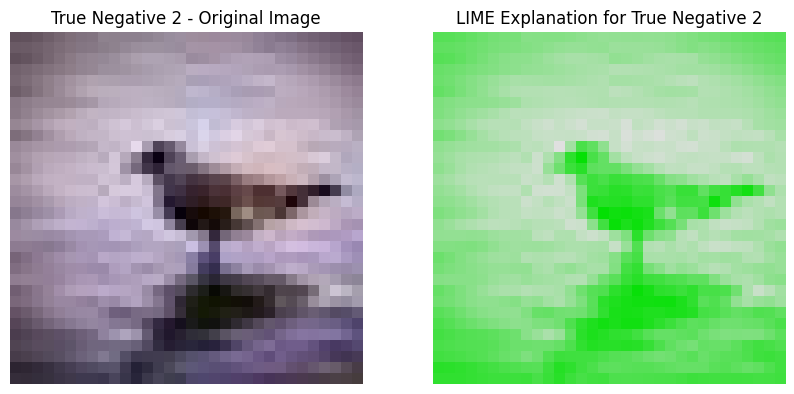

Generating LIME for False Positive 0


  0%|          | 0/50 [00:00<?, ?it/s]


Explanation for False Positive 0:

Feature 0: (0, 0.00036948624834963364)


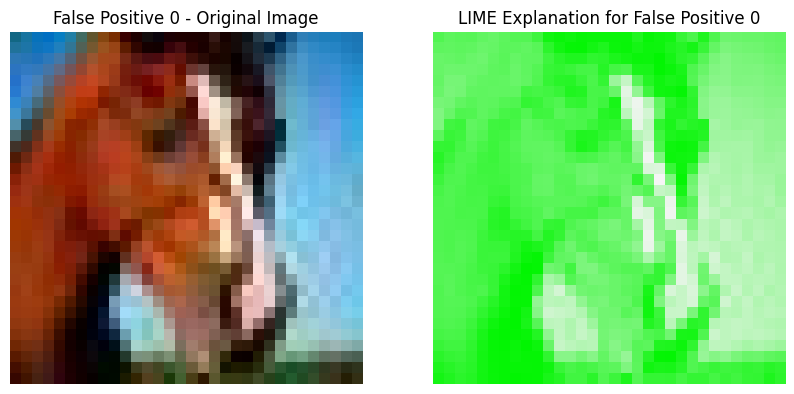

Generating LIME for False Positive 1


  0%|          | 0/50 [00:00<?, ?it/s]


Explanation for False Positive 1:

Feature 0: (0, 0.00036728025696201747)


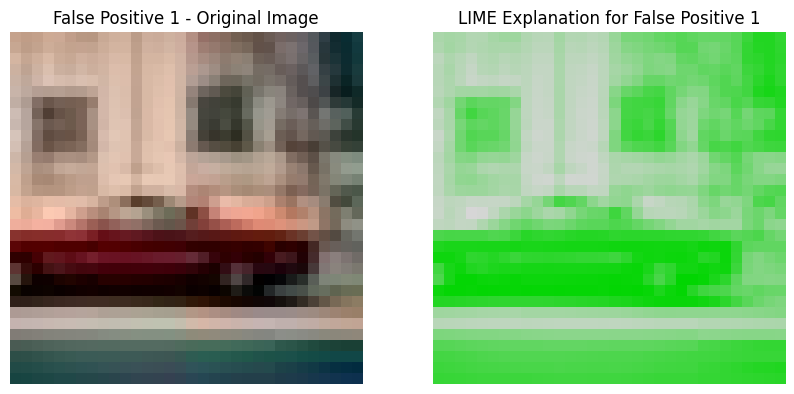

Generating LIME for False Positive 2


  0%|          | 0/50 [00:00<?, ?it/s]


Explanation for False Positive 2:

Feature 0: (0, 0.00040789479703989183)


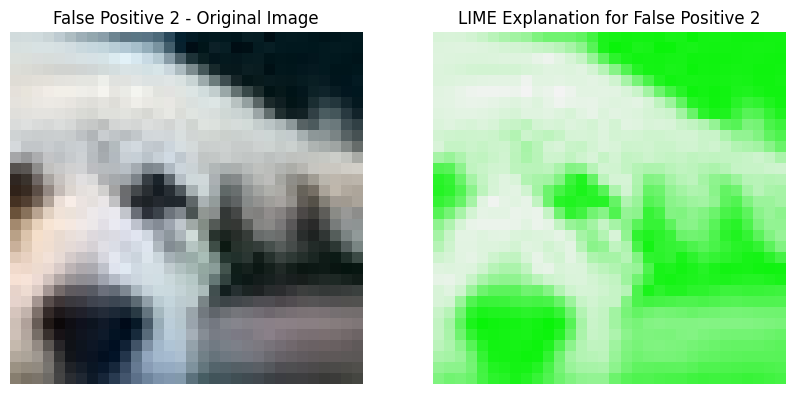

Generating LIME for False Negative 0


  0%|          | 0/50 [00:00<?, ?it/s]


Explanation for False Negative 0:

Feature 0: (0, 0.00032633757730419236)


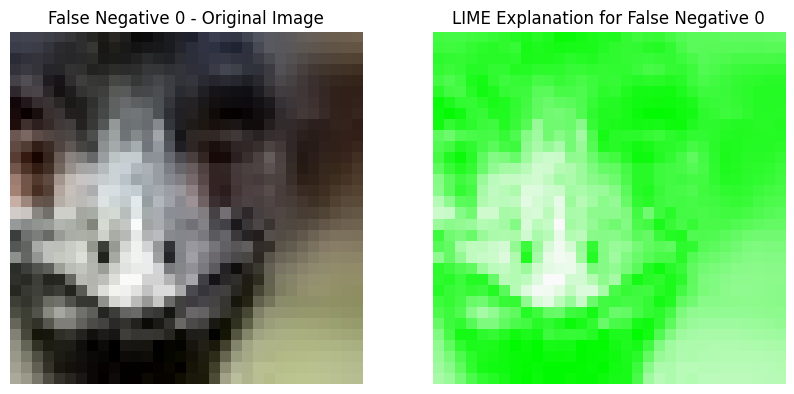

Generating LIME for False Negative 1


  0%|          | 0/50 [00:00<?, ?it/s]


Explanation for False Negative 1:

Feature 0: (0, 0.0002665272274413026)


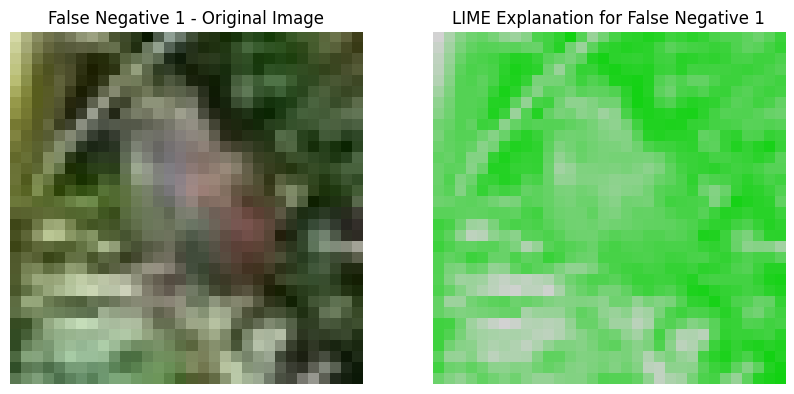

Generating LIME for False Negative 2


  0%|          | 0/50 [00:00<?, ?it/s]


Explanation for False Negative 2:

Feature 0: (0, 0.00032576530960679907)


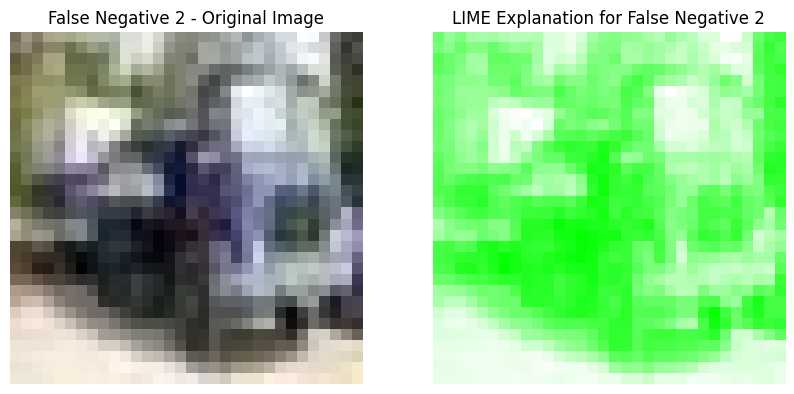

In [15]:
import lime
import lime.lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
from catboost import CatBoostClassifier

# Redefine the predict_proba function for LIME to predict using the CatBoost model
def predict_proba_fn(images):
    # Extract features for each image in the batch
    features = np.array([extract_features(image) for image in images])
    features = scaler.transform(features)  # Scale the features using the fitted scaler
    return catboost_model.predict_proba(features)  # Use the CatBoost model to predict probabilities

# Initialize LIME explainer for images
explainer = lime.lime_image.LimeImageExplainer()

# Load original images for X_test (before feature extraction)
def load_images(base_path):
    images, labels = [], []
    for label in ['real', 'fake']:
        folder_path = os.path.join(base_path, label)
        for image_name in os.listdir(folder_path):
            image_path = os.path.join(folder_path, image_name)
            image = cv2.imread(image_path)
            images.append(image)
            labels.append(1 if label == 'real' else 0)  # 1 for real, 0 for fake
    return np.array(images), np.array(labels)

# Function to classify images into TP, TN, FP, FN
def classify_images(y_true, y_pred):
    tp = np.where((y_true == 1) & (y_pred == 1))[0]  # True Positives
    tn = np.where((y_true == 0) & (y_pred == 0))[0]  # True Negatives
    fp = np.where((y_true == 0) & (y_pred == 1))[0]  # False Positives
    fn = np.where((y_true == 1) & (y_pred == 0))[0]  # False Negatives
    return tp, tn, fp, fn

# Apply LIME to test dataset with original images and visualize TP, TN, FP, FN
def apply_lime_to_dataset(images, labels, dataset_type='Test'):
    # Predict the labels using the classifier (for classification of TP, TN, FP, FN)
    y_pred = catboost_model.predict([extract_features(image) for image in images])
    
    tp, tn, fp, fn = classify_images(labels, y_pred)
    
    # Limit to 3 images per classification
    tp = tp[:3]
    tn = tn[:3]
    fp = fp[:3]
    fn = fn[:3]
    
    # Create the folder structure for saving images
    output_folder = f"lime_catboost/{dataset_type}"
    os.makedirs(output_folder, exist_ok=True)

    # Save and display the LIME explanations for each classification type
    for i, idx in enumerate(tp):
        print(f"Generating LIME for True Positive {i}")
        save_and_display_lime(images[idx], f"True Positive {i}", output_folder)
    
    for i, idx in enumerate(tn):
        print(f"Generating LIME for True Negative {i}")
        save_and_display_lime(images[idx], f"True Negative {i}", output_folder)
    
    for i, idx in enumerate(fp):
        print(f"Generating LIME for False Positive {i}")
        save_and_display_lime(images[idx], f"False Positive {i}", output_folder)
    
    for i, idx in enumerate(fn):
        print(f"Generating LIME for False Negative {i}")
        save_and_display_lime(images[idx], f"False Negative {i}", output_folder)

# Function to generate LIME explanations, visualize, and display in console as well as save them
def save_and_display_lime(image, label, output_folder):
    # Convert to grayscale for explanation
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Generate explanation for the instance
    explanation = explainer.explain_instance(
        image=gray_image,          # Pass the grayscale image
        classifier_fn=predict_proba_fn,  # Prediction function using CatBoost model
        top_labels=2,               # Number of top labels to explain
        hide_color=0,               # Color to hide areas (black in this case)
        num_samples=50            # Number of perturbations LIME will generate
    )

    # Display explanation in console
    print(f"\nExplanation for {label}:\n")
    for i, feature in enumerate(explanation.local_exp[explanation.top_labels[0]]):
        print(f"Feature {i}: {feature}")

    # Visualize the explanation with boundaries
    temp, mask = explanation.get_image_and_mask(
        explanation.top_labels[0],  # Label to explain
        positive_only=False,        # Show both positive and negative contributions
        num_features=10,            # Number of superpixels (features) to show
        hide_rest=False             # Show the entire image
    )

    # Prepare filenames
    original_image_filename = os.path.join(output_folder, f"{label}_original.jpg")
    lime_image_filename = os.path.join(output_folder, f"{label}_lime.jpg")

    # Plot and save the original image with LIME explanation
    plt.figure(figsize=(10, 10))

    # Display original image
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(f'{label} - Original Image')
    plt.axis('off')  # Turn off axis

    # Display LIME explanation with boundaries
    plt.subplot(1, 2, 2)
    plt.imshow(mark_boundaries(temp, mask, color=(1, 0, 0), mode='thick'))
    plt.title(f'LIME Explanation for {label}')
    plt.axis('off')  # Turn off axis

    # Save the plot
    plt.savefig(lime_image_filename)
    
    # Show the image in the console (pop-up window)
    plt.show()  # This will pop up the image in a GUI window
    
    # Close the plot window
    plt.close()

# Load original train and test images (before feature extraction)
base_path_train = r"C:\Desktop\ML_Implementation\data(Final_ML)\train"
base_path_test = r"C:\Desktop\ML_Implementation\data(Final_ML)\test"

image_train, y_train = load_images(base_path_train)
image_test, y_test = load_images(base_path_test)

# Initialize CatBoost model with parameters
catboost_model = CatBoostClassifier(iterations=1000, depth=6, learning_rate=0.1, random_seed=42, verbose=0)

# Fit the CatBoost model on the training data
catboost_model.fit([extract_features(image) for image in image_train], y_train)

# Apply LIME to the train dataset (True Positive, True Negative, False Positive, False Negative)
print("Applying LIME to Train Dataset...")
apply_lime_to_dataset(image_train, y_train, dataset_type='train')

# Apply LIME to the test dataset (True Positive, True Negative, False Positive, False Negative)
print("Applying LIME to Test Dataset...")
apply_lime_to_dataset(image_test, y_test, dataset_type='test')


In [16]:
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
from xgboost import XGBClassifier

# Initialize the XGBoost Classifier
xgb_model = XGBClassifier(n_estimators=200, learning_rate=0.1, max_depth=5, random_state=42)

# Fit the model to the training data
xgb_model.fit(X_train, y_train)

# Function to generate and save classification results to Excel
def save_classification_results(model, X, y, dataset_type, excel_writer):
    # Make predictions
    y_pred = model.predict(X)
    
    # Generate classification report and confusion matrix
    class_report = classification_report(y, y_pred, output_dict=True)
    conf_matrix = confusion_matrix(y, y_pred)
    
    # Convert classification report to DataFrame and save to Excel
    class_report_df = pd.DataFrame(class_report).transpose()
    class_report_df.to_excel(excel_writer, sheet_name=f"{dataset_type}_Classification_Report")
    
    # Convert confusion matrix to DataFrame and save to Excel
    conf_matrix_df = pd.DataFrame(
        conf_matrix,
        index=[f"True_{label}" for label in model.classes_],
        columns=[f"Pred_{label}" for label in model.classes_]
    )
    conf_matrix_df.to_excel(excel_writer, sheet_name=f"{dataset_type}_Confusion_Matrix")
    print(f"{dataset_type} results saved to Excel.")

# Create an Excel writer
with pd.ExcelWriter("xgboost_class.xlsx") as writer:
    # Save training results
    save_classification_results(xgb_model, X_train, y_train, "Training", writer)
    
    # Save testing results
    save_classification_results(xgb_model, X_test, y_test, "Testing", writer)

print("Classification results for both training and testing datasets have been saved to 'xgboost_class.xlsx'.")


Training results saved to Excel.
Testing results saved to Excel.
Classification results for both training and testing datasets have been saved to 'xgboost_class.xlsx'.


Applying LIME to Train Dataset...
Generating LIME for True Positive 0


  0%|          | 0/50 [00:00<?, ?it/s]


Explanation for True Positive 0:

Feature 0: (1, -0.0036831095491627174)
Feature 1: (0, 0.002156443836905945)


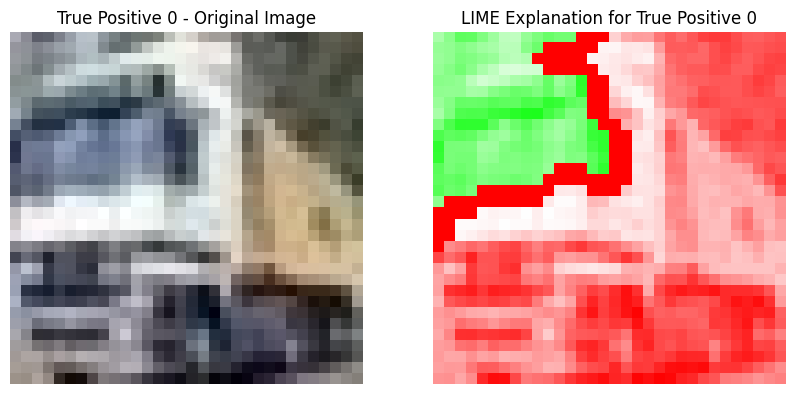

Generating LIME for True Positive 1


  0%|          | 0/50 [00:00<?, ?it/s]


Explanation for True Positive 1:

Feature 0: (0, 0.0003122978934529835)


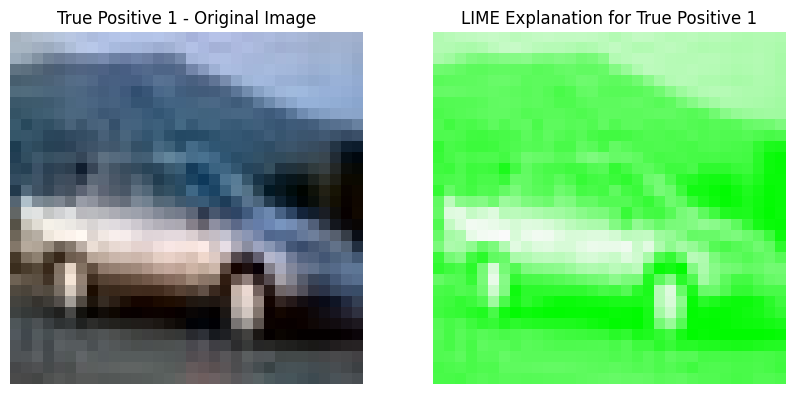

Generating LIME for True Positive 2


  0%|          | 0/50 [00:00<?, ?it/s]


Explanation for True Positive 2:

Feature 0: (0, 0.00033543728022847254)


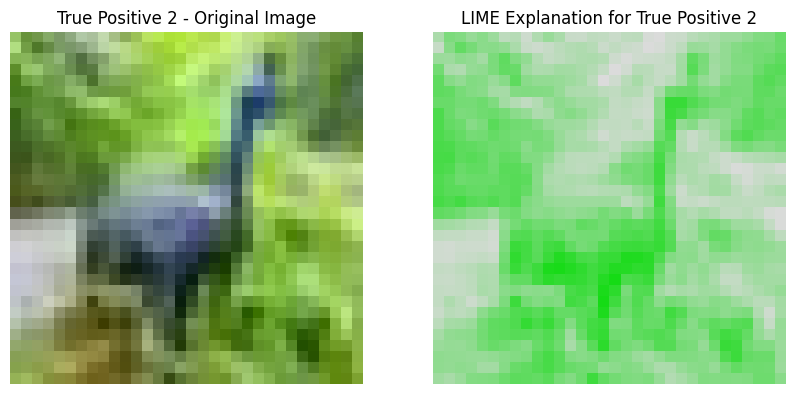

Generating LIME for True Negative 0


  0%|          | 0/50 [00:00<?, ?it/s]


Explanation for True Negative 0:

Feature 0: (1, -0.005833275776131644)
Feature 1: (0, -0.004627467843895433)


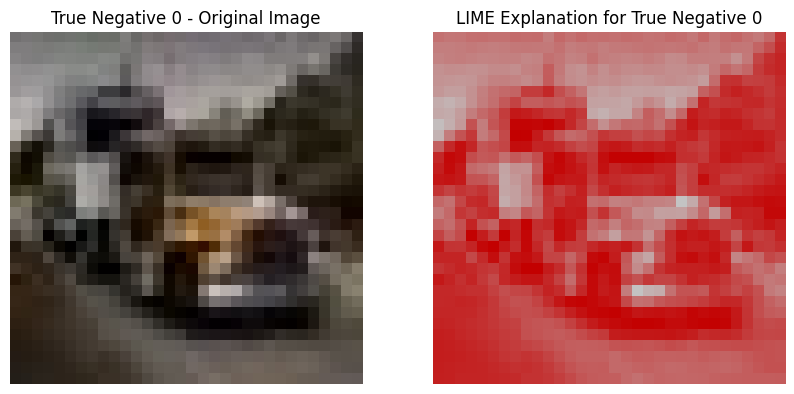

Generating LIME for True Negative 1


  0%|          | 0/50 [00:00<?, ?it/s]


Explanation for True Negative 1:

Feature 0: (0, 0.013574751011764991)
Feature 1: (1, -0.001050256787324336)


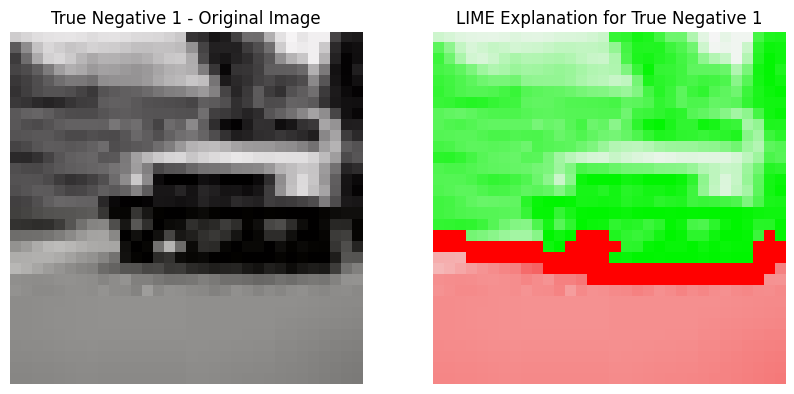

Generating LIME for True Negative 2


  0%|          | 0/50 [00:00<?, ?it/s]


Explanation for True Negative 2:

Feature 0: (0, 0.0002904023147177533)


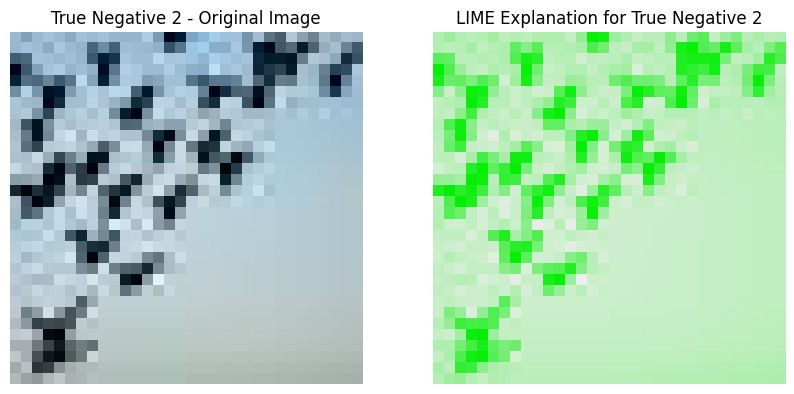

Applying LIME to Test Dataset...
Generating LIME for True Positive 0


  0%|          | 0/50 [00:00<?, ?it/s]


Explanation for True Positive 0:

Feature 0: (0, 0.00035549065333083987)


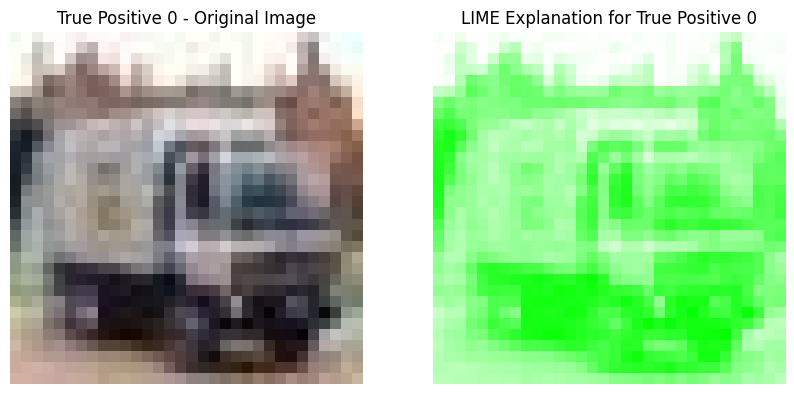

Generating LIME for True Positive 1


  0%|          | 0/50 [00:00<?, ?it/s]


Explanation for True Positive 1:

Feature 0: (0, 0.0002852198914355381)


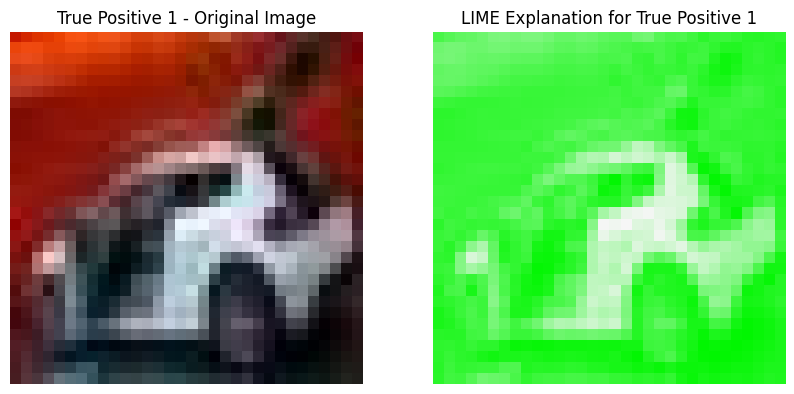

Generating LIME for True Positive 2


  0%|          | 0/50 [00:00<?, ?it/s]


Explanation for True Positive 2:

Feature 0: (0, 0.00033998802762818213)


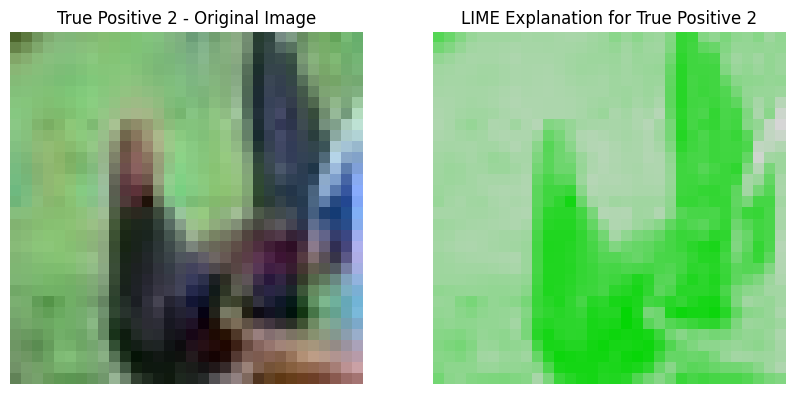

Generating LIME for True Negative 0


  0%|          | 0/50 [00:00<?, ?it/s]


Explanation for True Negative 0:

Feature 0: (1, -0.004675178703028451)
Feature 1: (0, -0.0014962449530628956)


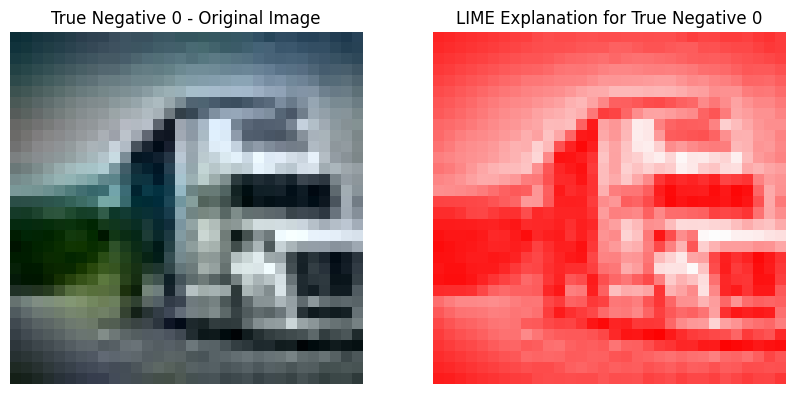

Generating LIME for True Negative 1


  0%|          | 0/50 [00:00<?, ?it/s]


Explanation for True Negative 1:

Feature 0: (0, 0.0004168508032088803)


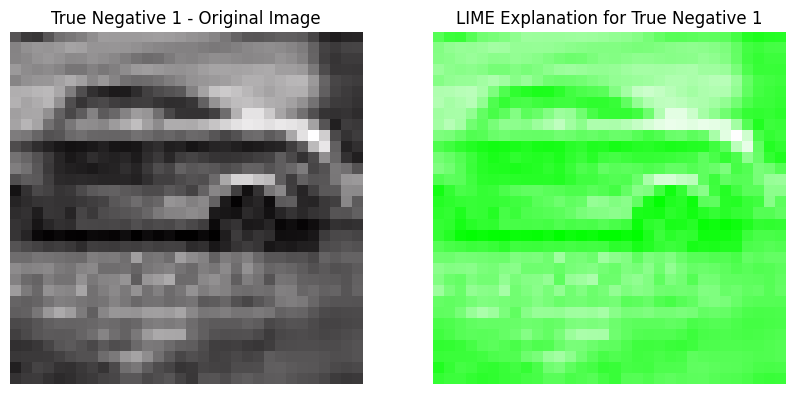

Generating LIME for True Negative 2


  0%|          | 0/50 [00:00<?, ?it/s]


Explanation for True Negative 2:

Feature 0: (0, 0.007257342470371669)
Feature 1: (1, 0.001027915454091393)


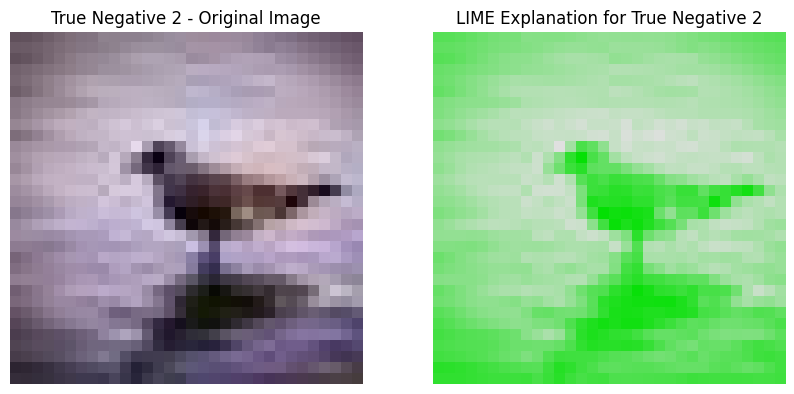

Generating LIME for False Positive 0


  0%|          | 0/50 [00:00<?, ?it/s]


Explanation for False Positive 0:

Feature 0: (0, 0.00036044526061753345)


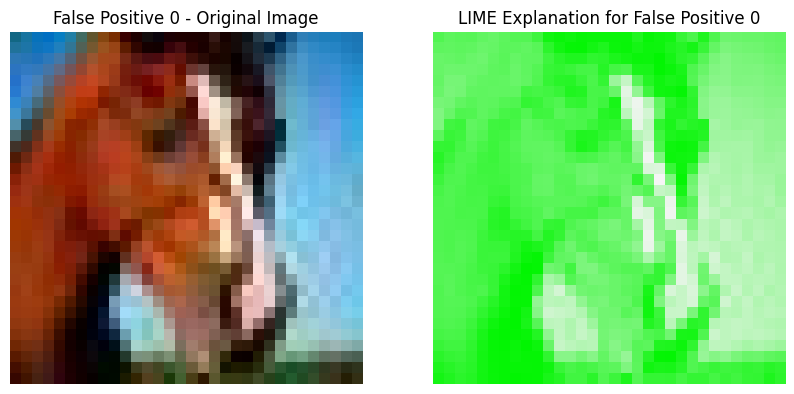

Generating LIME for False Positive 1


  0%|          | 0/50 [00:00<?, ?it/s]


Explanation for False Positive 1:

Feature 0: (0, 0.0002770034813874675)


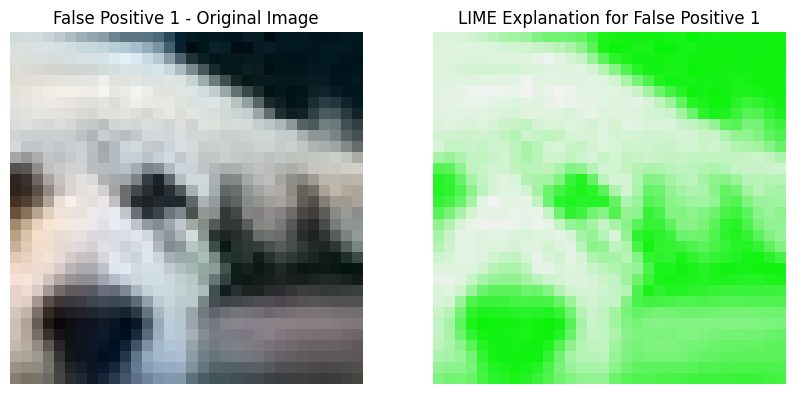

Generating LIME for False Positive 2


  0%|          | 0/50 [00:00<?, ?it/s]


Explanation for False Positive 2:

Feature 0: (0, 0.00019233831016743106)


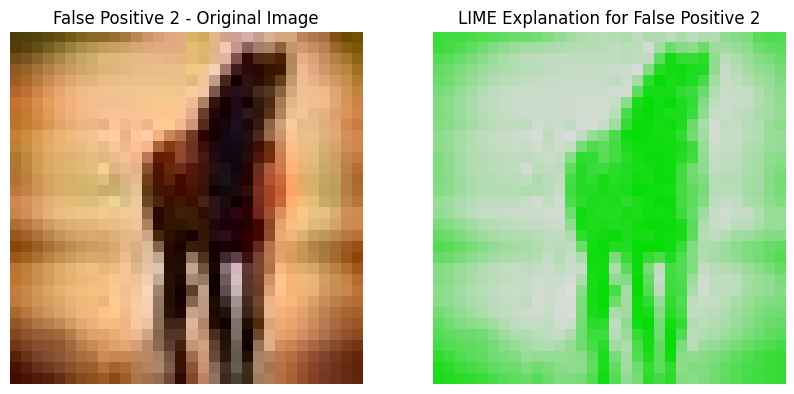

Generating LIME for False Negative 0


  0%|          | 0/50 [00:00<?, ?it/s]


Explanation for False Negative 0:

Feature 0: (0, 0.00034348291692370714)


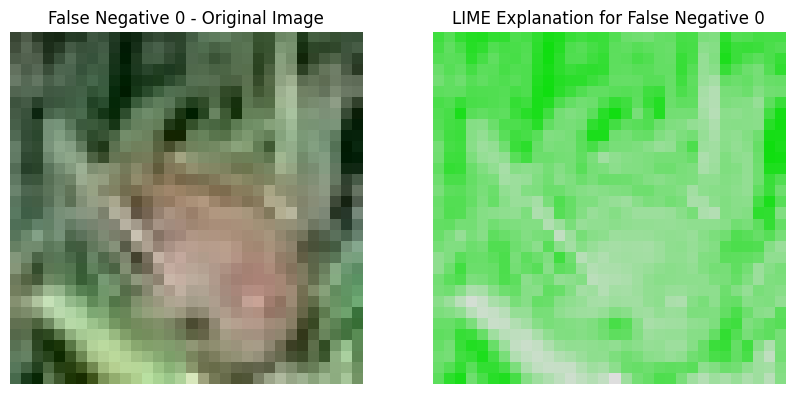

Generating LIME for False Negative 1


  0%|          | 0/50 [00:00<?, ?it/s]


Explanation for False Negative 1:

Feature 0: (0, 0.00034729422800720974)


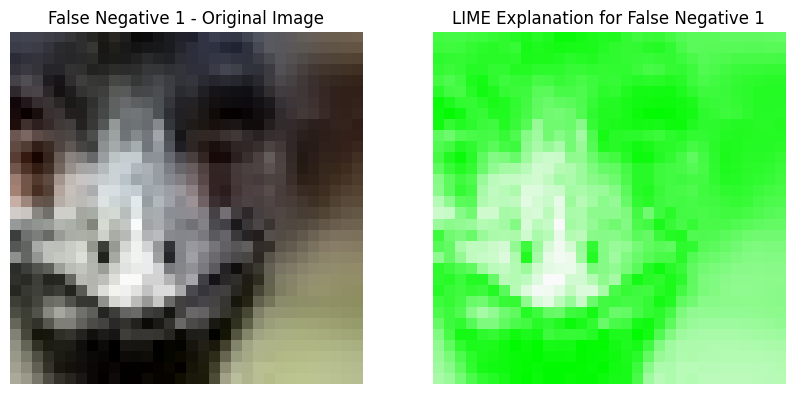

Generating LIME for False Negative 2


  0%|          | 0/50 [00:00<?, ?it/s]


Explanation for False Negative 2:

Feature 0: (0, 0.0004990750969372146)


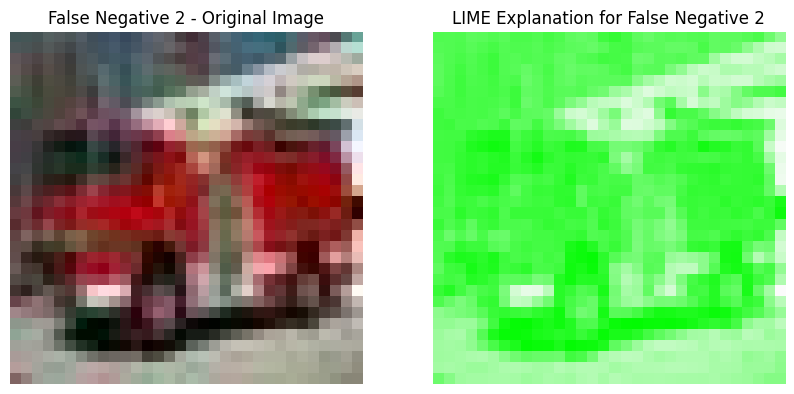

In [17]:
import lime
import lime.lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
from xgboost import XGBClassifier

# Redefine the predict_proba function for LIME to predict using the XGBoost model
def predict_proba_fn(images):
    # Extract features for each image in the batch
    features = np.array([extract_features(image) for image in images])
    features = scaler.transform(features)  # Scale the features using the fitted scaler
    return xgb_model.predict_proba(features)  # Use the XGBoost model to predict probabilities

# Initialize LIME explainer for images
explainer = lime.lime_image.LimeImageExplainer()

# Load original images for X_test (before feature extraction)
def load_images(base_path):
    images, labels = [], []
    for label in ['real', 'fake']:
        folder_path = os.path.join(base_path, label)
        for image_name in os.listdir(folder_path):
            image_path = os.path.join(folder_path, image_name)
            image = cv2.imread(image_path)
            images.append(image)
            labels.append(1 if label == 'real' else 0)  # 1 for real, 0 for fake
    return np.array(images), np.array(labels)

# Function to classify images into TP, TN, FP, FN
def classify_images(y_true, y_pred):
    tp = np.where((y_true == 1) & (y_pred == 1))[0]  # True Positives
    tn = np.where((y_true == 0) & (y_pred == 0))[0]  # True Negatives
    fp = np.where((y_true == 0) & (y_pred == 1))[0]  # False Positives
    fn = np.where((y_true == 1) & (y_pred == 0))[0]  # False Negatives
    return tp, tn, fp, fn

# Apply LIME to test dataset with original images and visualize TP, TN, FP, FN
def apply_lime_to_dataset(images, labels, dataset_type='Test'):
    # Predict the labels using the classifier (for classification of TP, TN, FP, FN)
    y_pred = xgb_model.predict([extract_features(image) for image in images])
    
    tp, tn, fp, fn = classify_images(labels, y_pred)
    
    # Limit to 3 images per classification
    tp = tp[:3]
    tn = tn[:3]
    fp = fp[:3]
    fn = fn[:3]
    
    # Create the folder structure for saving images
    output_folder = f"lime_xgboost/{dataset_type}"
    os.makedirs(output_folder, exist_ok=True)

    # Save and display the LIME explanations for each classification type
    for i, idx in enumerate(tp):
        print(f"Generating LIME for True Positive {i}")
        save_and_display_lime(images[idx], f"True Positive {i}", output_folder)
    
    for i, idx in enumerate(tn):
        print(f"Generating LIME for True Negative {i}")
        save_and_display_lime(images[idx], f"True Negative {i}", output_folder)
    
    for i, idx in enumerate(fp):
        print(f"Generating LIME for False Positive {i}")
        save_and_display_lime(images[idx], f"False Positive {i}", output_folder)
    
    for i, idx in enumerate(fn):
        print(f"Generating LIME for False Negative {i}")
        save_and_display_lime(images[idx], f"False Negative {i}", output_folder)

# Function to generate LIME explanations, visualize, and display in console as well as save them
def save_and_display_lime(image, label, output_folder):
    # Convert to grayscale for explanation
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Generate explanation for the instance
    explanation = explainer.explain_instance(
        image=gray_image,          # Pass the grayscale image
        classifier_fn=predict_proba_fn,  # Prediction function using XGBoost model
        top_labels=2,               # Number of top labels to explain
        hide_color=0,               # Color to hide areas (black in this case)
        num_samples=50            # Number of perturbations LIME will generate
    )

    # Display explanation in console
    print(f"\nExplanation for {label}:\n")
    for i, feature in enumerate(explanation.local_exp[explanation.top_labels[0]]):
        print(f"Feature {i}: {feature}")

    # Visualize the explanation with boundaries
    temp, mask = explanation.get_image_and_mask(
        explanation.top_labels[0],  # Label to explain
        positive_only=False,        # Show both positive and negative contributions
        num_features=10,            # Number of superpixels (features) to show
        hide_rest=False             # Show the entire image
    )

    # Prepare filenames
    original_image_filename = os.path.join(output_folder, f"{label}_original.jpg")
    lime_image_filename = os.path.join(output_folder, f"{label}_lime.jpg")

    # Plot and save the original image with LIME explanation
    plt.figure(figsize=(10, 10))

    # Display original image
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(f'{label} - Original Image')
    plt.axis('off')  # Turn off axis

    # Display LIME explanation with boundaries
    plt.subplot(1, 2, 2)
    plt.imshow(mark_boundaries(temp, mask, color=(1, 0, 0), mode='thick'))
    plt.title(f'LIME Explanation for {label}')
    plt.axis('off')  # Turn off axis

    # Save the plot
    plt.savefig(lime_image_filename)
    
    # Show the image in the console (pop-up window)
    plt.show()  # This will pop up the image in a GUI window
    
    # Close the plot window
    plt.close()

# Load original train and test images (before feature extraction)
base_path_train = r"C:\Desktop\ML_Implementation\data(Final_ML)\train"
base_path_test = r"C:\Desktop\ML_Implementation\data(Final_ML)\test"

image_train, y_train = load_images(base_path_train)
image_test, y_test = load_images(base_path_test)

# Initialize XGBoost model with parameters
xgb_model = XGBClassifier(n_estimators=200, max_depth=6, learning_rate=0.1, random_state=42)

# Fit the XGBoost model on the training data
xgb_model.fit([extract_features(image) for image in image_train], y_train)

# Apply LIME to the train dataset
print("Applying LIME to Train Dataset...")
apply_lime_to_dataset(image_train, y_train, dataset_type='train')

# Apply LIME to the test dataset
print("Applying LIME to Test Dataset...")
apply_lime_to_dataset(image_test, y_test, dataset_type='test')


In [18]:
import pandas as pd
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix

# Initialize the Naive Bayes Classifier
naive_bayes_model = GaussianNB()

# Fit the model to the training data
naive_bayes_model.fit(X_train, y_train)

# Make predictions on the training set
y_train_pred = naive_bayes_model.predict(X_train)

# Make predictions on the test set
y_test_pred = naive_bayes_model.predict(X_test)

# Get classification reports for both train and test sets
train_class_report = classification_report(y_train, y_train_pred, output_dict=True)
test_class_report = classification_report(y_test, y_test_pred, output_dict=True)

# Get confusion matrices for both train and test sets
train_conf_matrix = confusion_matrix(y_train, y_train_pred)
test_conf_matrix = confusion_matrix(y_test, y_test_pred)

# Create a pandas DataFrame to store the results for both training and testing
# Convert classification report into a DataFrame
train_class_report_df = pd.DataFrame(train_class_report).transpose()
test_class_report_df = pd.DataFrame(test_class_report).transpose()

# Save the classification report and confusion matrix to Excel
with pd.ExcelWriter('naive_class.xlsx') as writer:
    # Save classification reports to separate sheets
    train_class_report_df.to_excel(writer, sheet_name='Train Classification Report')
    test_class_report_df.to_excel(writer, sheet_name='Test Classification Report')
    
    # Save confusion matrices to separate sheets
    pd.DataFrame(train_conf_matrix).to_excel(writer, sheet_name='Train Confusion Matrix')
    pd.DataFrame(test_conf_matrix).to_excel(writer, sheet_name='Test Confusion Matrix')

print("Results saved to 'naive_class.xlsx'")

print(test_conf_matrix)
print(train_conf_matrix)

Results saved to 'naive_class.xlsx'
[[713 252]
 [338 882]]
[[1890  617]
 [ 812 2046]]


Applying LIME to Train Dataset...
Generating LIME for True Positive 0


  0%|          | 0/50 [00:00<?, ?it/s]


Explanation for True Positive 0:

Feature 0: (0, 0.0009164019194173019)
Feature 1: (1, 0.0005463761304417561)


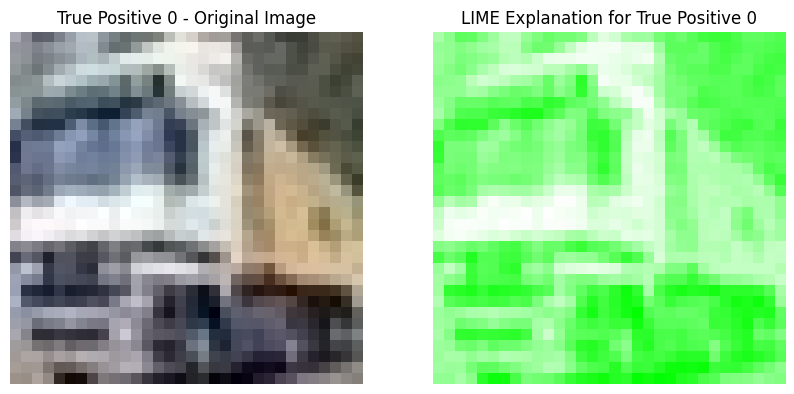

Generating LIME for True Positive 1


  0%|          | 0/50 [00:00<?, ?it/s]


Explanation for True Positive 1:

Feature 0: (0, -1.5862063866407957e-14)


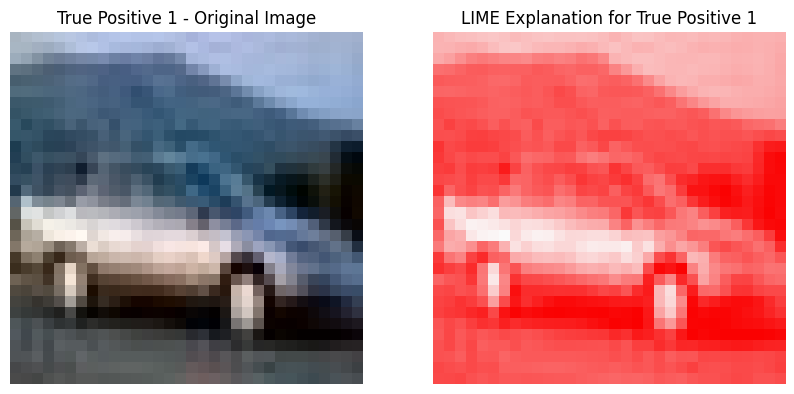

Generating LIME for True Positive 2


  0%|          | 0/50 [00:00<?, ?it/s]


Explanation for True Positive 2:

Feature 0: (0, -3.1770034027958358e-15)


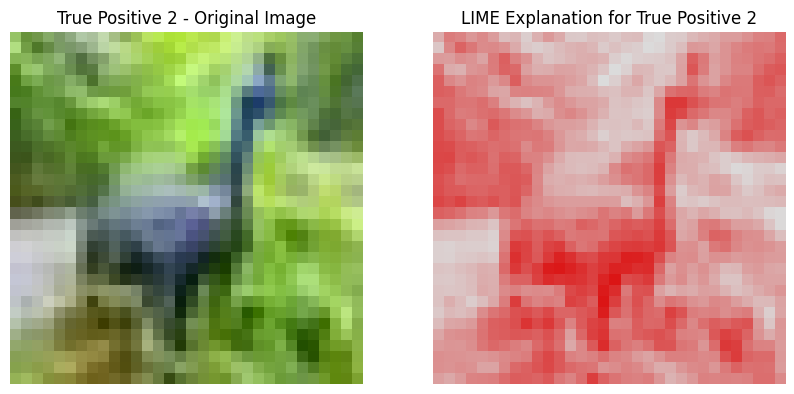

Generating LIME for False Positive 0


  0%|          | 0/50 [00:00<?, ?it/s]


Explanation for False Positive 0:

Feature 0: (0, 0.0007089529666306965)
Feature 1: (1, 0.0005993599366612442)


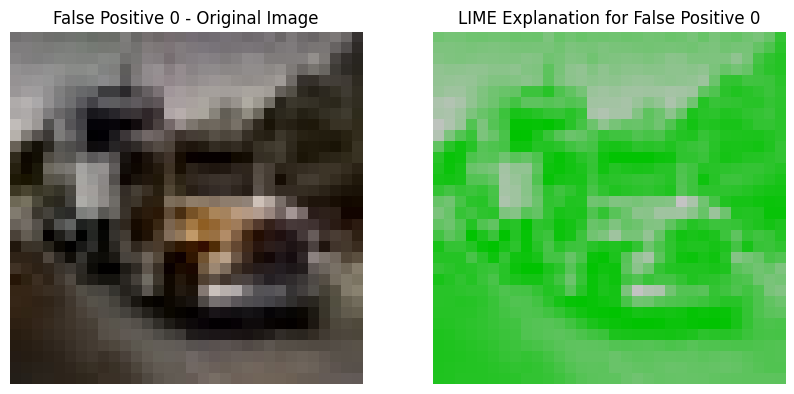

Generating LIME for False Positive 1


  0%|          | 0/50 [00:00<?, ?it/s]


Explanation for False Positive 1:

Feature 0: (1, 0.0008159965228257426)
Feature 1: (0, 0.000776906524285463)


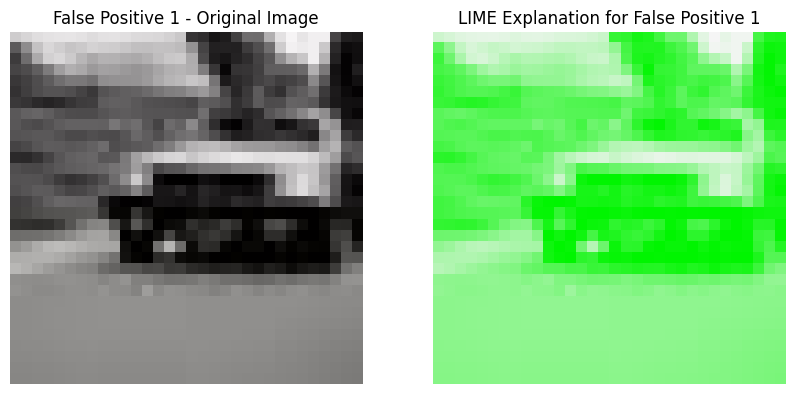

Generating LIME for False Positive 2


  0%|          | 0/50 [00:00<?, ?it/s]


Explanation for False Positive 2:

Feature 0: (0, 0.00930161261954191)


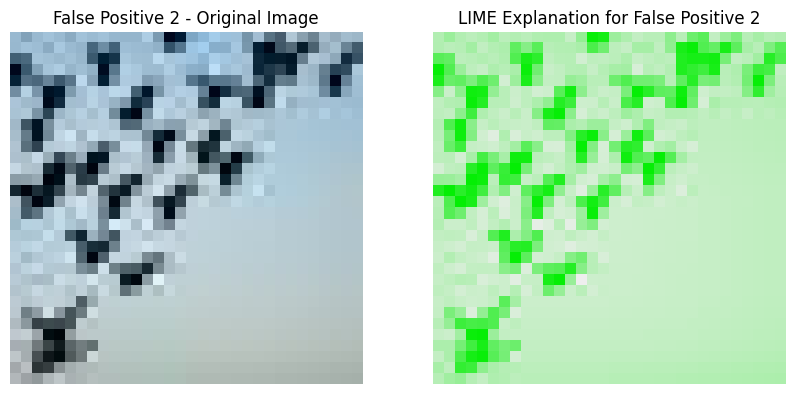

Generating LIME for False Negative 0


  0%|          | 0/50 [00:00<?, ?it/s]


Explanation for False Negative 0:

Feature 0: (2, 0.21527433521445155)
Feature 1: (0, 0.15470874980584004)
Feature 2: (1, 0.13799493556453882)


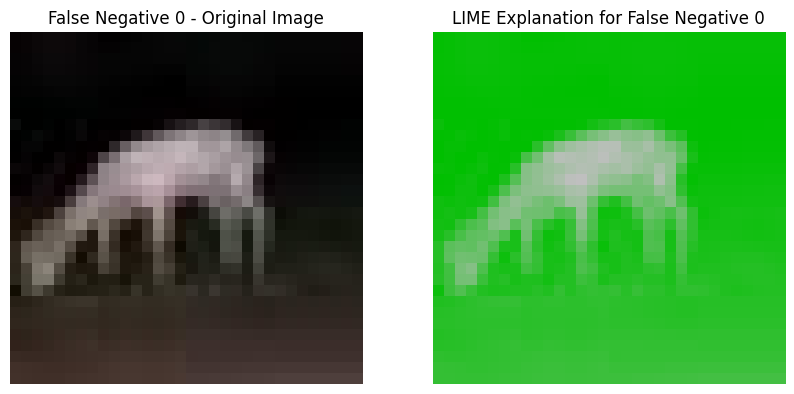

Generating LIME for False Negative 1


  0%|          | 0/50 [00:00<?, ?it/s]


Explanation for False Negative 1:

Feature 0: (0, 0.007962173503061193)


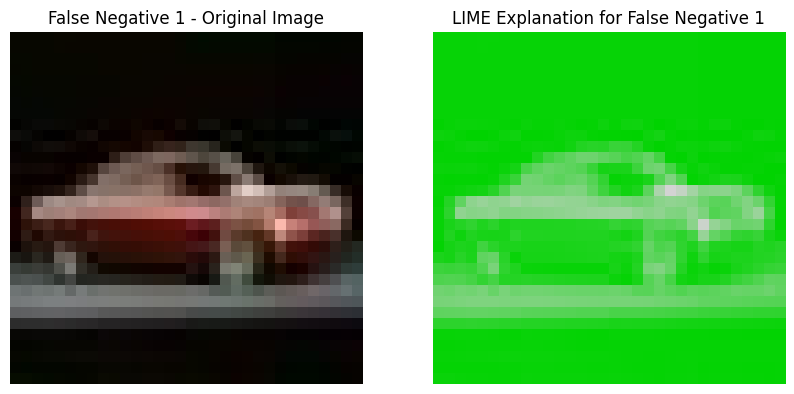

Generating LIME for False Negative 2


  0%|          | 0/50 [00:00<?, ?it/s]


Explanation for False Negative 2:

Feature 0: (0, 0.0)


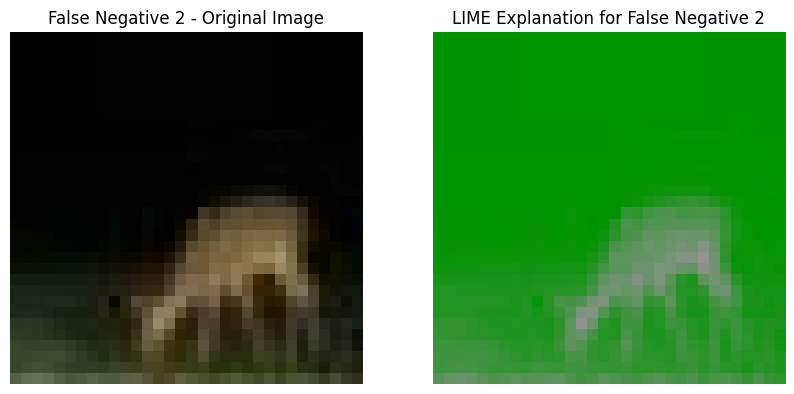

Applying LIME to Test Dataset...
Generating LIME for True Positive 0


  0%|          | 0/50 [00:00<?, ?it/s]


Explanation for True Positive 0:

Feature 0: (0, 0.0)


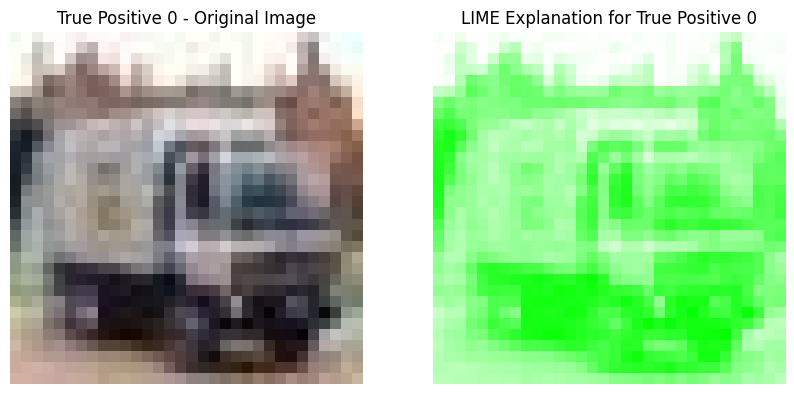

Generating LIME for True Positive 1


  0%|          | 0/50 [00:00<?, ?it/s]


Explanation for True Positive 1:

Feature 0: (0, 0.007984347841210044)


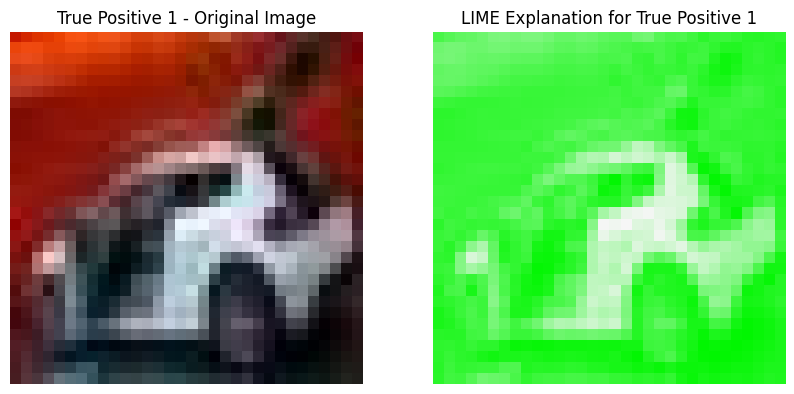

Generating LIME for True Positive 2


  0%|          | 0/50 [00:00<?, ?it/s]


Explanation for True Positive 2:

Feature 0: (0, -5.409982937332337e-13)


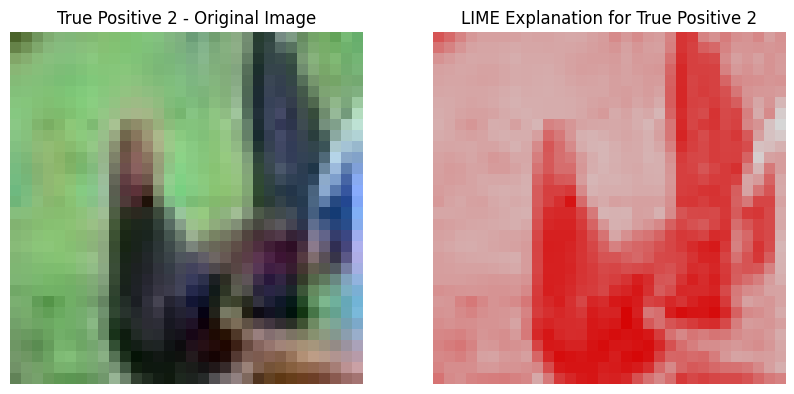

Generating LIME for True Negative 0


  0%|          | 0/50 [00:00<?, ?it/s]


Explanation for True Negative 0:

Feature 0: (0, 0.0009872820387264386)
Feature 1: (1, 0.0009351700423216031)


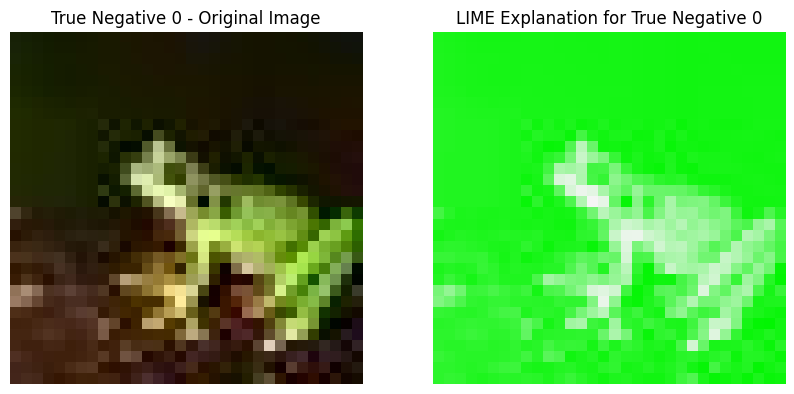

Generating LIME for False Positive 0


  0%|          | 0/50 [00:00<?, ?it/s]


Explanation for False Positive 0:

Feature 0: (0, 0.00045215013990284995)
Feature 1: (1, 0.0003768264283454465)


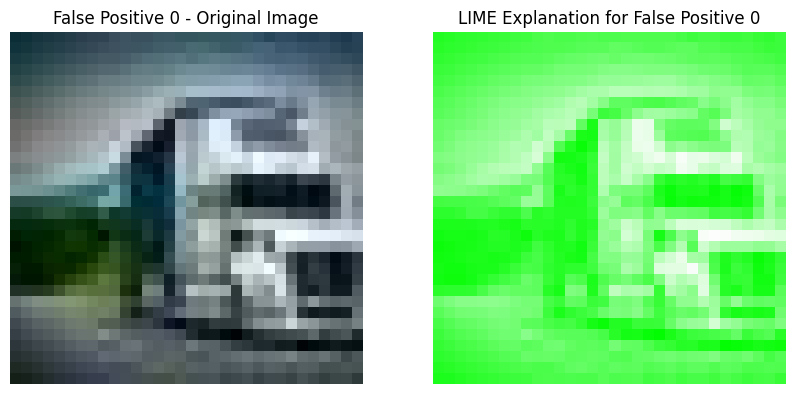

Generating LIME for False Positive 1


  0%|          | 0/50 [00:00<?, ?it/s]


Explanation for False Positive 1:

Feature 0: (0, 0.00930161261954191)


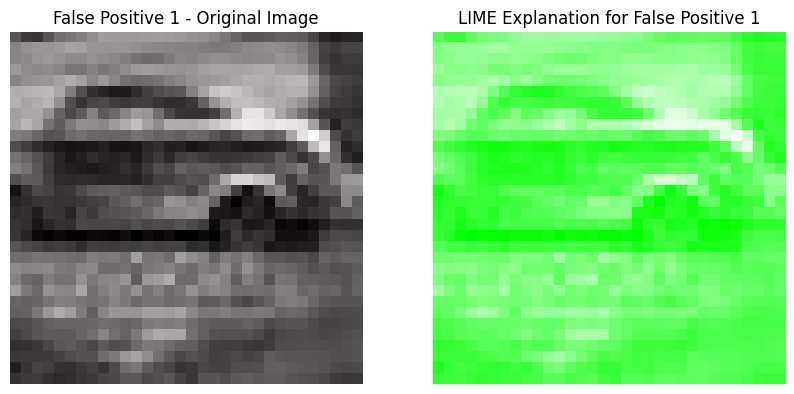

Generating LIME for False Positive 2


  0%|          | 0/50 [00:00<?, ?it/s]


Explanation for False Positive 2:

Feature 0: (0, 0.0007586486887210498)
Feature 1: (1, 0.0007165379365647558)


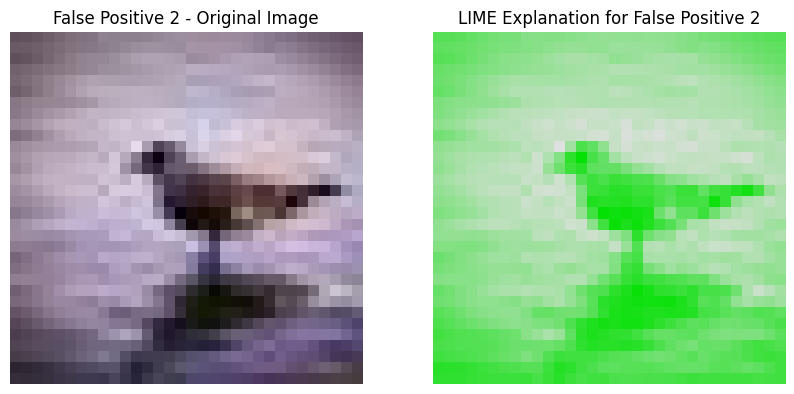

In [19]:
import lime
import lime.lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler

# Redefine the predict_proba function for LIME to predict using the Naive Bayes model
def predict_proba_fn(images):
    # Extract features for each image in the batch
    features = np.array([extract_features(image) for image in images])
    features = scaler.transform(features)  # Scale the features using the fitted scaler
    return naive_bayes_model.predict_proba(features)  # Use the Naive Bayes model to predict probabilities

# Initialize LIME explainer for images
explainer = lime.lime_image.LimeImageExplainer()

# Load original images for X_test (before feature extraction)
def load_images(base_path):
    images, labels = [], []
    for label in ['real', 'fake']:
        folder_path = os.path.join(base_path, label)
        for image_name in os.listdir(folder_path):
            image_path = os.path.join(folder_path, image_name)
            image = cv2.imread(image_path)
            images.append(image)
            labels.append(1 if label == 'real' else 0)  # 1 for real, 0 for fake
    return np.array(images), np.array(labels)

# Function to classify images into TP, TN, FP, FN
def classify_images(y_true, y_pred):
    tp = np.where((y_true == 1) & (y_pred == 1))[0]  # True Positives
    tn = np.where((y_true == 0) & (y_pred == 0))[0]  # True Negatives
    fp = np.where((y_true == 0) & (y_pred == 1))[0]  # False Positives
    fn = np.where((y_true == 1) & (y_pred == 0))[0]  # False Negatives
    return tp, tn, fp, fn

# Apply LIME to test dataset with original images and visualize TP, TN, FP, FN
def apply_lime_to_dataset(images, labels, dataset_type='Test'):
    # Predict the labels using the classifier (for classification of TP, TN, FP, FN)
    y_pred = naive_bayes_model.predict([extract_features(image) for image in images])
    
    tp, tn, fp, fn = classify_images(labels, y_pred)
    
    # Limit to 3 images per classification
    tp = tp[:3]
    tn = tn[:3]
    fp = fp[:3]
    fn = fn[:3]
    
    # Create the folder structure for saving images
    output_folder = f"lime_naive_bayes/{dataset_type}"
    os.makedirs(output_folder, exist_ok=True)

    # Save and display the LIME explanations for each classification type
    for i, idx in enumerate(tp):
        print(f"Generating LIME for True Positive {i}")
        save_and_display_lime(images[idx], f"True Positive {i}", output_folder)
    
    for i, idx in enumerate(tn):
        print(f"Generating LIME for True Negative {i}")
        save_and_display_lime(images[idx], f"True Negative {i}", output_folder)
    
    for i, idx in enumerate(fp):
        print(f"Generating LIME for False Positive {i}")
        save_and_display_lime(images[idx], f"False Positive {i}", output_folder)
    
    for i, idx in enumerate(fn):
        print(f"Generating LIME for False Negative {i}")
        save_and_display_lime(images[idx], f"False Negative {i}", output_folder)

# Function to generate LIME explanations, visualize, and display in console as well as save them
def save_and_display_lime(image, label, output_folder):
    # Convert to grayscale for explanation
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Generate explanation for the instance
    explanation = explainer.explain_instance(
        image=gray_image,          # Pass the grayscale image
        classifier_fn=predict_proba_fn,  # Prediction function using Naive Bayes model
        top_labels=2,               # Number of top labels to explain
        hide_color=0,               # Color to hide areas (black in this case)
        num_samples=50            # Number of perturbations LIME will generate
    )

    # Display explanation in console
    print(f"\nExplanation for {label}:\n")
    for i, feature in enumerate(explanation.local_exp[explanation.top_labels[0]]):
        print(f"Feature {i}: {feature}")

    # Visualize the explanation with boundaries
    temp, mask = explanation.get_image_and_mask(
        explanation.top_labels[0],  # Label to explain
        positive_only=False,        # Show both positive and negative contributions
        num_features=10,            # Number of superpixels (features) to show
        hide_rest=False             # Show the entire image
    )

    # Prepare filenames
    original_image_filename = os.path.join(output_folder, f"{label}_original.jpg")
    lime_image_filename = os.path.join(output_folder, f"{label}_lime.jpg")

    # Plot and save the original image with LIME explanation
    plt.figure(figsize=(10, 10))

    # Display original image
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(f'{label} - Original Image')
    plt.axis('off')  # Turn off axis

    # Display LIME explanation with boundaries
    plt.subplot(1, 2, 2)
    plt.imshow(mark_boundaries(temp, mask, color=(1, 0, 0), mode='thick'))
    plt.title(f'LIME Explanation for {label}')
    plt.axis('off')  # Turn off axis

    # Save the plot
    plt.savefig(lime_image_filename)
    
    # Show the image in the console (pop-up window)
    plt.show()  # This will pop up the image in a GUI window
    
    # Close the plot window
    plt.close()

# Load original train and test images (before feature extraction)
base_path_train = r"C:\Desktop\ML_Implementation\data(Final_ML)\train"
base_path_test = r"C:\Desktop\ML_Implementation\data(Final_ML)\test"

image_train, y_train = load_images(base_path_train)
image_test, y_test = load_images(base_path_test)

# Initialize Naive Bayes model with parameters
naive_bayes_model = GaussianNB()

# Initialize StandardScaler (for scaling features)
scaler = StandardScaler()

# Fit the Naive Bayes model on the training data
features_train = np.array([extract_features(image) for image in image_train])
features_train_scaled = scaler.fit_transform(features_train)
naive_bayes_model.fit(features_train_scaled, y_train)

# Apply LIME to the train dataset (True Positive, True Negative, False Positive, False Negative)
print("Applying LIME to Train Dataset...")
apply_lime_to_dataset(image_train, y_train, dataset_type='train')

# Apply LIME to the test dataset (True Positive, True Negative, False Positive, False Negative)
print("Applying LIME to Test Dataset...")
apply_lime_to_dataset(image_test, y_test, dataset_type='test')


In [20]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Initialize the Logistic Regression model
logreg_model = LogisticRegression(max_iter=200, random_state=42)

# Fit the model to the training data
logreg_model.fit(X_train, y_train)

# Function to generate and save classification results to Excel
def save_classification_results(model, X, y, dataset_type, excel_writer):
    # Make predictions
    y_pred = model.predict(X)
    
    # Generate classification report and confusion matrix
    class_report = classification_report(y, y_pred, output_dict=True)
    conf_matrix = confusion_matrix(y, y_pred)
    
    # Convert classification report to DataFrame and save to Excel
    class_report_df = pd.DataFrame(class_report).transpose()
    class_report_df.to_excel(excel_writer, sheet_name=f"{dataset_type}_Classification_Report")
    
    # Convert confusion matrix to DataFrame and save to Excel
    conf_matrix_df = pd.DataFrame(
        conf_matrix,
        index=[f"True_{label}" for label in model.classes_],
        columns=[f"Pred_{label}" for label in model.classes_]
    )
    conf_matrix_df.to_excel(excel_writer, sheet_name=f"{dataset_type}_Confusion_Matrix")
    print(f"{dataset_type} results saved to Excel.")

# Create an Excel writer
with pd.ExcelWriter("logreg_class.xlsx") as writer:
    # Save training results
    save_classification_results(logreg_model, X_train, y_train, "Training", writer)
    
    # Save testing results
    save_classification_results(logreg_model, X_test, y_test, "Testing", writer)

print("Classification results for both training and testing datasets have been saved to 'logreg_class.xlsx'.")


Training results saved to Excel.
Testing results saved to Excel.
Classification results for both training and testing datasets have been saved to 'logreg_class.xlsx'.


C:\Users\ru368\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [21]:
import lime
import lime.lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

# Redefine the predict_fn function for LIME to predict using the Linear Regression model
def predict_fn(images):
    # Extract features for each image in the batch
    features = np.array([extract_features(image) for image in images])
    features = scaler.transform(features)  # Scale the features using the fitted scaler
    return naive_bayes_model.predict(features).reshape(-1, 1)  # Use the Linear Regression model to predict values

# Initialize LIME explainer for images
explainer = lime.lime_image.LimeImageExplainer()

# Load original images for X_test (before feature extraction)
def load_images(base_path):
    images, labels = [], []
    for label in ['real', 'fake']:
        folder_path = os.path.join(base_path, label)
        for image_name in os.listdir(folder_path):
            image_path = os.path.join(folder_path, image_name)
            image = cv2.imread(image_path)
            images.append(image)
            labels.append(1 if label == 'real' else 0)  # 1 for real, 0 for fake
    return np.array(images), np.array(labels)

# Apply LIME to test dataset with original images and visualize TP, TN, FP, FN
def apply_lime_to_dataset(images, labels, dataset_type='Test'):
    # Predict the labels using the classifier (for classification of TP, TN, FP, FN)
    y_pred = naive_bayes_model.predict([extract_features(image) for image in images])
    
    tp, tn, fp, fn = classify_images(labels, y_pred)
    
    # Limit to 3 images per classification
    tp = tp[:3]
    tn = tn[:3]
    fp = fp[:3]
    fn = fn[:3]
    
    # Create the folder structure for saving images
    output_folder = f"lime_linear_regression/{dataset_type}"
    os.makedirs(output_folder, exist_ok=True)

    # Save and display the LIME explanations for each classification type
    for i, idx in enumerate(tp):
        print(f"Generating LIME for True Positive {i}")
        save_and_display_lime(images[idx], f"True Positive {i}", output_folder)
    
    for i, idx in enumerate(tn):
        print(f"Generating LIME for True Negative {i}")
        save_and_display_lime(images[idx], f"True Negative {i}", output_folder)
    
    for i, idx in enumerate(fp):
        print(f"Generating LIME for False Positive {i}")
        save_and_display_lime(images[idx], f"False Positive {i}", output_folder)
    
    for i, idx in enumerate(fn):
        print(f"Generating LIME for False Negative {i}")
        save_and_display_lime(images[idx], f"False Negative {i}", output_folder)

# Function to generate LIME explanations, visualize, and display in console as well as save them
def save_and_display_lime(image, label, output_folder):
    # Convert to grayscale for explanation
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Generate explanation for the instance
    explanation = explainer.explain_instance(
        image=gray_image,          # Pass the grayscale image
        classifier_fn=predict_fn,  # Prediction function using Linear Regression model
        top_labels=1,               # For regression, we only need the predicted value (not multiple labels)
        hide_color=0,               # Color to hide areas (black in this case)
        num_samples=50            # Number of perturbations LIME will generate
    )

    # Display explanation in console
    print(f"\nExplanation for {label}:\n")
    for i, feature in enumerate(explanation.local_exp[explanation.top_labels[0]]):
        print(f"Feature {i}: {feature}")

    # Visualize the explanation with boundaries
    temp, mask = explanation.get_image_and_mask(
        explanation.top_labels[0],  # Label to explain
        positive_only=False,        # Show both positive and negative contributions
        num_features=10,            # Number of superpixels (features) to show
        hide_rest=False             # Show the entire image
    )

    # Prepare filenames
    original_image_filename = os.path.join(output_folder, f"{label}_original.jpg")
    lime_image_filename = os.path.join(output_folder, f"{label}_lime.jpg")

    # Plot and save the original image with LIME explanation
    plt.figure(figsize=(10, 10))

    # Display original image
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(f'{label} - Original Image')
    plt.axis('off')  # Turn off axis

    # Display LIME explanation with boundaries
    plt.subplot(1, 2, 2)
    plt.imshow(mark_boundaries(temp, mask, color=(1, 0, 0), mode='thick'))
    plt.title(f'LIME Explanation for {label}')
    plt.axis('off')  # Turn off axis

    # Save the plot
    plt.savefig(lime_image_filename)
    
    # Show the image in the console (pop-up window)
    plt.show()  # This will pop up the image in a GUI window
    
    # Close the plot window
    plt.close()

# Load original train and test images (before feature extraction)
base_path_train = r"C:\Desktop\ML_Implementation\data(Final_ML)\train"
base_path_test = r"C:\Desktop\ML_Implementation\data(Final_ML)\test"

image_train, y_train = load_images(base_path_train)
image_test, y_test = load_images(base_path_test)

# Initialize Linear Regression model
naive_bayes_model = LinearRegression()

# Initialize StandardScaler (for scaling features)
scaler = StandardScaler()

# Fit the Linear Regression model on the training data
features_train = np.array([extract_features(image) for image in image_train])
features_train_scaled = scaler.fit_transform(features_train)
naive_bayes_model.fit(features_train_scaled, y_train)

# Apply LIME to the train dataset (True Positive, True Negative, False Positive, False Negative)
print("Applying LIME to Train Dataset...")
apply_lime_to_dataset(image_train, y_train, dataset_type='train')

# Apply LIME to the test dataset (True Positive, True Negative, False Positive, False Negative)
print("Applying LIME to Test Dataset...")
apply_lime_to_dataset(image_test, y_test, dataset_type='test')


Applying LIME to Train Dataset...
Applying LIME to Test Dataset...


In [22]:
import os
import numpy as np
import cv2
from tkinter import *
from tkinter import filedialog
from PIL import Image, ImageTk
import joblib
from catboost import CatBoostClassifier
from sklearn.preprocessing import StandardScaler
from pywt import dwt2

# Function for extracting features
def extract_features(image):
    # Convert image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # DCT
    dct_features = cv2.dct(np.float32(gray) / 255.0)
    dct_features = dct_features.flatten()[:100]  # Top 100 coefficients

    # Pad or trim to make it exactly 100 coefficients if necessary
    if len(dct_features) < 100:
        dct_features = np.pad(dct_features, (0, 100 - len(dct_features)), 'constant')
    else:
        dct_features = dct_features[:100]

    # Wavelet Transform
    coeffs2 = dwt2(gray, 'haar')
    cA, (cH, cV, cD) = coeffs2
    wavelet_features = np.concatenate([cA.flatten(), cH.flatten(), cV.flatten(), cD.flatten()])[:100]

    # Pad or trim to make it exactly 100 coefficients if necessary
    if len(wavelet_features) < 100:
        wavelet_features = np.pad(wavelet_features, (0, 100 - len(wavelet_features)), 'constant')
    else:
        wavelet_features = wavelet_features[:100]

    # FFT
    f = np.fft.fft2(gray)
    fshift = np.fft.fftshift(f)
    epsilon = 1e-10  # To avoid log(0)
    magnitude_spectrum = 20 * np.log(np.abs(fshift) + epsilon)
    fft_features = magnitude_spectrum.flatten()[:100]  # Top 100 coefficients

    # Pad or trim to make it exactly 100 coefficients if necessary
    if len(fft_features) < 100:
        fft_features = np.pad(fft_features, (0, 100 - len(fft_features)), 'constant')
    else:
        fft_features = fft_features[:100]

    # Combine features
    features = np.concatenate([dct_features, wavelet_features, fft_features])

    # Check for NaN or infinite values
    if np.any(np.isnan(features)) or np.any(np.isinf(features)):
        return None  # Return None for invalid features

    return features

# Load the saved model and scaler
catboost_model = joblib.load('catboost_model_with_metrics.pkl')
scaler = joblib.load('scaler.pkl')

# Function to open file dialog and predict the image
def upload_image():
    # Open file dialog to select image
    file_path = filedialog.askopenfilename(title="Select an Image", filetypes=(("JPEG files", "*.jpg;*.jpeg"), ("All files", "*.*")))
    if file_path:
        # Display the selected image
        image = Image.open(file_path)
        image = image.resize((250, 250), Image.Resampling.LANCZOS)  # Updated line for resizing
        photo = ImageTk.PhotoImage(image)

        # Display image in the window
        label_image.config(image=photo)
        label_image.image = photo

        # Use the CatBoost model to predict the label
        prediction = catboost_model.predict(features_scaled)
        if prediction:
            label_prediction.config(text=f"Prediction: {prediction}")
        else:
            label_prediction.config(text="Error: Invalid image")

# Create the main window
root = Tk()
root.title("Image Classification - Real or Fake")

# Create a button to upload images
button_upload = Button(root, text="Upload Image", command=upload_image)
button_upload.pack(pady=20)

# Create a label to display the uploaded image
label_image = Label(root)
label_image.pack(pady=20)

# Create a label to display the prediction result
label_prediction = Label(root, text="Prediction: ", font=("Helvetica", 16))
label_prediction.pack(pady=20)

# Start the Tkinter event loop
root.mainloop()
